<p style="font-size:14pt;text-align:center;">
Pretraining network on pascal VOC.
</p>

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import theano
from theano import tensor as T
import pickle as pk
import re
from copy import deepcopy
import sys

# image processing
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2hsv, hsv2rgb

import lasagne
from lasagne.layers import Pool2DLayer, Conv2DLayer, dropout, \
    DenseLayer, InputLayer, get_output, get_all_params
    
import bnr_ml.objectdetect.yolo as yolo

import pdb

/Users/colingaudreau/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using gpu device 0: GeForce GTX 960 (CNMeM is enabled with initial size: 80.0% of memory, cuDNN not available)
/Library/Python/2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
with open('/usr/local/python/bnr_ml/data/PascalVOC/annotations.txt', 'rb') as f:
    annotations = pk.load(f)['annotations']

In [3]:
def add_proper_labels(annotations):
    for im in annotations:
        for obj in im:
            if 'car' in obj['label'].lower():
                obj['label'] = 'car'
            elif 'bicycle' in obj['label'].lower():
                obj['label'] = 'bicycle'
            elif 'person' in obj['label'].lower():
                obj['label'] = 'person'
            elif 'bike' in obj['label'].lower():
                obj['label'] = 'bike'
            else:
                print obj

In [4]:
def get_label_counts(annotations):
    counts = np.zeros((4,))
    for im in annotations:
        for obj in im:
            if obj['label'] == 'car':
                counts[0] += 1
            elif obj['label'] == 'bicycle':
                counts[1] += 1
            elif obj['label'] == 'bike':
                counts[2] += 1
            else:
                counts[3] += 1
    return counts

In [5]:
add_proper_labels(annotations)

In [6]:
annotations = np.asarray(annotations)

In [7]:
counts = get_label_counts(annotations)

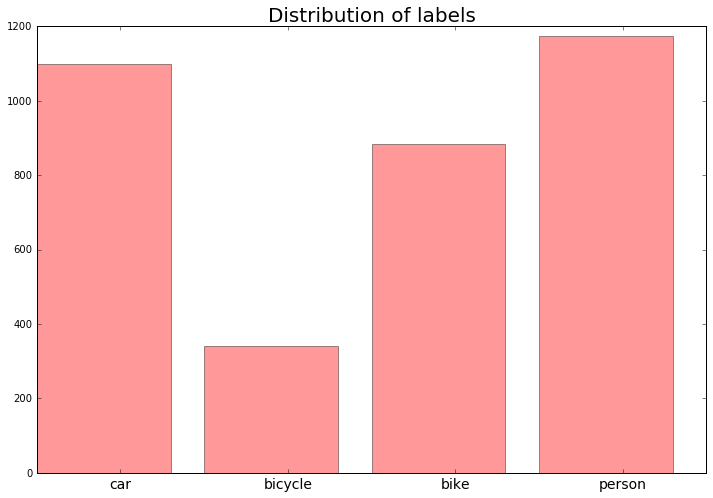

In [8]:
plt.figure(figsize=(12,8))
plt.title('Distribution of labels', fontsize=20)
plt.bar(np.arange(counts.size), counts, color='red', alpha=.4)
plt.xticks(np.arange(counts.size) + .5, ['car', 'bicycle', 'bike', 'person'], fontsize=14)
plt.show()

In [9]:
np.random.seed(1991)

<b>Split the annotations for training and testing, the reason I split by image and not individual object is so that when testing the performance, the network will never have seen any part of the test image.

In [10]:
with open('indices.pkl', 'rb') as f:
    indices = pk.load(f)
    train_idx = indices['train_index']
    test_idx = indices['test_index']

In [11]:
train_annotations = annotations[train_idx]
test_annotations = annotations[test_idx]

In [12]:
class Box(object):
    def __init__(self, xi,yi,xf,yf):
        self.xi = xi
        self.yi = yi
        self.xf = xf
        self.yf = yf
    def iou(self, box):
        isec = self.intersection(box)
        union = self.size() + box.size() - isec.size()
        return isec.size() / union
    def intersection(self, box):
        new_xi = max(self.xi, box.xi)
        new_yi = max(self.yi, box.yi)
        new_xf = min(self.xf, box.xf)
        new_yf = min(self.yf, box.yf)
        if new_xi > new_xf or new_yi > new_yf:
            new_xi, new_yi, new_xf, new_yf = 0., 0., 0., 0.
        return Box(new_xi, new_yi, new_xf, new_yf)
    def size(self):
        return (self.xf - self.xi) * (self.yf - self.yi)
    def width(self):
        return (self.xf - self.xi)
    def height(self):
        return (self.yf - self.yi)
    def copy(self):
        return Box(self.xi, self.yi, self.xf, self.yf)
    def subimage(self, im):
        xi = max(0, self.xi)
        yi = max(0, self.yi)
        xf = min(im.shape[1], self.xf)
        yf = min(im.shape[0], self.yf)
        return im[yi:yf, xi:xf]
    def round(self):
        self.xi, self.yi, self.xf, self.yf = round(self.xi), round(self.yi), round(self.xf), round(self.yf)
    def __str__(self):
        return '(' + str(self.xi) + ',' + str(self.yi) + ') (' + str(self.xf) + ',' + str(self.yf) + ')'
    def __repr__(self):
        return self.__str__()
    @staticmethod
    def gen_randombox(iou, box, eps=.5):
        angle = 2 * np.pi * np.random.rand()
        delx, dely = eps*np.cos(angle), eps*np.sin(angle)
        new_box = box.copy()
        while new_box.iou(box) > iou:
            new_box.xi += delx
            new_box.yi += dely
            new_box.xf += delx
            new_box.yf += dely
        return new_box

In [378]:
def generate_data(annotations, C, size=(200,200), batch_size=100):
    '''
    augment: how many times do you want the data to be replicated
    '''
    def get_objects(annotations):
        objs = []
        for im in annotations:
            objs.extend([deepcopy(obj) for obj in im])
        return np.asarray(objs)
    def get_num_from_label(label):
        if label == 'car':
            return 0
        elif label == 'bicycle':
            return 1
        elif label == 'bike':
            return 2
        elif label == 'person':
            return 3
        elif label == 'noobj':
            return 4
        else:
            pass
#             print('This shouldn\'t happen')
    def subsample_objs(objs, obj_idx, size):
        idx = obj_idx[np.random.random_integers(0,obj_idx.size-1, size=(size,))]
        copy_obj = []
        for obj in objs[idx]:
            copy_obj.append(deepcopy(obj))
        return np.asarray(copy_obj)
    def set_label_to_noobj(objs, obj_idx):
        N = np.int_(np.float_(obj_idx.size) / 5)
        idx = np.arange(obj_idx.size)
        np.random.shuffle(idx)
        for obj in objs[obj_idx[idx[:N]]]:
            obj['label']  = 'noobj'
        return objs
    
    # return flat list of objects
    objs = get_objects(annotations)
    
    # get number from label
    labels = np.asarray([get_num_from_label(obj['label']) for obj in objs])
    
    idx = np.arange(labels.size)
    idx_car = idx[labels==0]
    idx_bicycle = idx[labels==1]
    idx_bike = idx[labels==2]
    idx_person = idx[labels==3]
        
    max_labels = np.max([idx_car.size, idx_bicycle.size, idx_bike.size, idx_person.size])
    
    # get subsamples to get equal number of classes
    new_car = subsample_objs(objs, idx_car, max_labels - idx_car.size)
    new_bicycle = subsample_objs(objs, idx_bicycle, max_labels - idx_bicycle.size)
    new_bike = subsample_objs(objs, idx_bike, max_labels - idx_bike.size)
    new_person = subsample_objs(objs, idx_person, max_labels - idx_person.size)
    
    # add new samples
    objs = np.concatenate((objs, new_car, new_bicycle, new_bike, new_person))
    
    np.random.shuffle(objs)
    
    cnt = 0
    while cnt < objs.size:
        Xbatch = np.zeros((batch_size, 3) + size)
        ybatch = np.zeros((batch_size, 4 + C))
        batch_cnt = 0
        for j in range(batch_size):
            if cnt < objs.size:
                obj = objs[cnt]
                im = imread(obj['image'])
                im = im.astype(theano.config.floatX) / 255
                xscale, yscale = np.float_(size[1]) / im.shape[1], np.float_(size[0]) / im.shape[0]
#                 pdb.set_trace()
                coord = np.asarray(obj['p1'] + obj['p2']).astype(theano.config.floatX)
                coord[[0,2]] *= (xscale / 200)
                coord[[1,3]] *= (yscale / 200)
                if coord[2] >= coord[0]:
                    coord[2] -= coord[0]
                else:
                    coord[2] = coord[0] - coord[2]
                if coord[3] >= coord[1]:
                    coord[3] -= coord[1]
                else:
                    coord[3] = coord[1] - coord[3]
                    
                if coord[2] < 0 or coord[3] < 0:
                    print image
                    
                if im.shape.__len__() == 2:
                    im = im.reshape(im.shape + (1,))
                    im = np.concatenate((im, im, im), axis=2)
                elif im.shape[2] == 4:
                    im = im[:,:,:3]
                if not (im.shape[0] == 0 or im.shape[1] == 0):
                    im = resize(im, size).swapaxes(2,1).swapaxes(1,0)
                    Xbatch[batch_cnt] = im
                    ybatch[batch_cnt, :4] =  coord
                    ybatch[batch_cnt, 4 + get_num_from_label(obj['label'])] += 1
                    batch_cnt += 1
            cnt += 1
        if batch_cnt < batch_size - 1:
            Xbatch, ybatch = Xbatch[:batch_cnt], ybatch[:batch_cnt]
        yield Xbatch.astype(theano.config.floatX), ybatch.astype(theano.config.floatX)

<b>Now we define the net for recognition.</b>

In [385]:
net = {}
net['input'] = InputLayer((None,3,200,200))
net['conv1'] = Conv2DLayer(net['input'], 16, (3,3))
net['conv2'] = Conv2DLayer(net['conv1'], 16, (3,3))
net['pool1'] = Pool2DLayer(net['conv2'], (2,2))
net['conv3'] = Conv2DLayer(net['pool1'], 32, (3,3))
net['conv4'] = Conv2DLayer(net['conv3'], 32, (3,3))
net['pool2'] = Pool2DLayer(net['conv4'], (2,2))
net['conv5'] = Conv2DLayer(net['pool2'], 64, (3,3))
net['conv6'] = Conv2DLayer(net['conv5'], 64, (3,3))
net['pool3'] = Pool2DLayer(net['conv6'], (2,2))
net['conv7'] = Conv2DLayer(net['pool3'], 64, (3,3))
net['conv8'] = Conv2DLayer(net['conv7'], 64, (3,3))
net['pool4'] = Pool2DLayer(net['conv8'], (2,2))
net['dense1'] = DenseLayer(dropout(net['pool4'], p=.8), 1000)
net['dense2'] = DenseLayer(dropout(net['dense1'], p=.8), 1000)
net['output'] = DenseLayer(dropout(net['dense2'], p=.5), 5, nonlinearity=lasagne.nonlinearities.softmax)

<b>Load pre-trained weights</b>

In [386]:
with open('pretrained_weights.pkl', 'rb') as f:
    weights = pk.load(f)
    lasagne.layers.set_all_param_values(net['output'], weights)

<b>Add extra layers to network for detection</b>

In [387]:
S = (6,6)
B = 2
C = 5

In [388]:
net['dense1'] = DenseLayer(dropout(net['pool4'], p=.9), 2048)
net['output'] = DenseLayer(dropout(net['dense1'], p=.9), (S[0] * S[1]) * (5 * B + C), nonlinearity=None)

In [389]:
load_weights = False
if load_weights:
    with open('yolo_weights.pkl', 'rb') as f:
        weights = pk.load(f)
        lasagne.layers.set_all_param_values(net['output'], weights)

<b>Train the network

In [390]:
num_epochs = 100
batch_size = 50

In [391]:
reload(yolo)

<module 'bnr_ml.objectdetect.yolo' from '/usr/local/python/bnr_ml/objectdetect/yolo.pyc'>

In [392]:
yl = yolo.YoloObjectDetector(net, (None, 3, 200, 200), C, S, B) 

In [393]:
train_loss, test_loss = yl.train(
    generate_data(train_annotations, C, batch_size=batch_size),
    generate_data(test_annotations, C, batch_size=batch_size),
    lr=1e-3,
    epochs=num_epochs
)

Getting cost...
Creating cost variable took 0.3872 seconds
Compiling...


  0%|          | 0/100 [00:00<?, ?it/s]

Compiling functions took 22.6562 seconds
Beginning training...
32.8344824219
26.556953125
45.9652978516
22.7582910156
26.1755859375
54.5193359375
23.9285302734
23.7507519531
18.1673779297
19.3872998047
19.6787585449
21.3000708008
20.9657397461
21.6509863281
19.4719934082
18.4993835449
16.866081543
20.4806274414
17.1145361328
16.818157959
18.5178918457
16.2612402344
18.3895825195
17.9209106445
19.6175109863
15.0253796387
15.585144043
18.001661377
15.5340551758
19.037142334
20.5152661133
16.6858044434
19.1739880371
17.6895727539
16.1373132324
17.8926696777
17.0779882813
15.83125
15.0191503906
14.8229150391
14.4945385742
14.6721166992
15.3438537598
14.818170166
15.0826928711
15.9572155762
16.5988500977
17.0326757812
13.7873205566
16.4675598145
14.9847924805
14.2198498535
16.0283911133
13.7815441895
15.399354248
14.867845459
16.0953198242
12.9592675781
14.2186669922
14.454465332
14.4649804687
14.8035754395
13.8399035645
12.8604760742
14.8770092773
14.3119665527
16.3051074219
13.7798376465


  1%|          | 1/100 [03:47<6:16:07, 227.96s/it]

Epoch 0
------
Train Loss: 18.0886, Test Loss: 12.8173
14.5069580078
12.7227807617
13.3962060547
13.0935717773
13.3108654785
14.5815283203
12.1207226563
14.9512683105
11.9618310547
13.2387097168
13.2158068848
15.3447253418
13.3424206543
13.9683691406
13.8016662598
13.5384277344
11.7916088867
15.0994873047
13.1576171875
13.8312438965
14.7608691406
12.8848669434
13.9730871582
13.8012329102
15.3815625
12.6839868164
12.4081384277
15.1821130371
12.2403674316
13.1850646973
14.8603857422
10.8082592773
15.5553173828
15.0246447754
13.2464648437
15.4468591309
13.9249035645
13.1411669922
11.5172045898
12.0207885742
12.0548474121
12.5782580566
13.1509765625
12.791463623
12.5775878906
14.023770752
14.0366052246
15.0835534668
11.4372045898
14.4788964844
12.7414953613
12.9699194336
13.4701538086
12.3522607422
13.4102160645
13.23203125
14.2317504883
11.7804052734
12.3962512207
12.9063574219
12.6797058105
13.5958862305
11.9761853027
11.585748291
12.7639758301
12.0625024414
14.3170251465
12.3339038086
1

  2%|▏         | 2/100 [04:34<4:43:31, 173.59s/it]

Epoch 1
------
Train Loss: 13.2930, Test Loss: 12.3544
13.3358007813
11.7752514648
12.2860998535
13.0652307129
12.5078369141
14.3304589844
11.186072998
14.2531018066
11.1789282227
12.6017700195
12.4518737793
14.390378418
12.7653894043
13.6641015625
12.6722949219
12.820390625
11.4490161133
14.8421044922
12.3790454102
13.1259313965
13.8752111816
12.3996813965
13.399720459
12.9455322266
14.7030664063
12.2061779785
11.9469018555
14.8865209961
11.6736547852
12.7886462402
14.2814208984
10.4041723633
15.5631323242
14.5100439453
12.9051184082
15.2220324707
13.429362793
12.8425939941
11.1415893555
11.9682727051
11.7187316895
12.3436730957
12.8471374512
12.1884643555
12.4345922852
13.155592041
13.6988391113
14.4064013672
11.0075219727
14.0063696289
12.5432434082
12.2488562012
13.4477990723
11.6975622559
13.0864196777
12.7037939453
14.0940637207
11.4066552734
11.8358813477
12.2783044434
12.2870715332
13.5164208984
11.9672070313
11.3970349121
12.5349157715
11.5279919434
14.1682702637
12.4830102539

  3%|▎         | 3/100 [05:21<3:39:06, 135.54s/it]

Epoch 2
------
Train Loss: 12.8335, Test Loss: 12.3946
13.4409692383
11.6241308594
11.8806469727
12.0264904785
12.1741967773
13.2072314453
11.1624633789
13.9556652832
11.0231738281
12.5195593262
12.1197106934
14.3564172363
12.4998010254
13.2664746094
12.5101928711
12.6196118164
11.1752441406
14.5287243652
12.2137634277
12.9207702637
13.8985266113
12.7542785645
13.3387243652
13.070612793
14.819095459
12.0178637695
12.0094213867
14.7525366211
11.5579309082
12.3217321777
14.3531164551
10.6288293457
15.1894140625
14.7149328613
12.7094714355
15.1145507812
13.31859375
12.5143383789
10.9637182617
11.9020227051
11.5581298828
12.1804101562
12.9463293457
12.4410705566
12.1558825684
13.4575305176
13.4799182129
14.6102648926
10.5714160156
14.3207165527
12.4540490723
12.3243066406
13.4299902344
11.8604443359
13.2963708496
12.8557922363
13.8943530273
11.5211181641
12.2041052246
12.2377856445
12.3745385742
13.5521911621
12.0474072266
11.3458410645
12.5990380859
11.7426940918
14.2807177734
12.27966918

  4%|▍         | 4/100 [06:08<2:54:14, 108.90s/it]

Epoch 3
------
Train Loss: 12.7511, Test Loss: 12.3815
13.1487304687
11.4787243652
11.9737670898
11.9581750488
12.4741833496
13.3354919434
11.2382861328
13.9730407715
10.9092578125
12.6898608398
12.3923352051
14.5581433105
12.6992016602
13.3940820313
12.5303295898
12.6007226562
11.1736315918
14.6731689453
12.1491333008
13.0627062988
13.8404003906
12.4504748535
13.2780554199
13.2370776367
14.470534668
11.9786877441
11.8838806152
14.8269592285
11.8191394043
12.4971594238
14.2822583008
10.5006115723
15.4668640137
14.6855737305
12.4601306152
15.2279333496
13.2903051758
12.5141296387
10.9519091797
11.7120129395
11.501953125
12.2365393066
12.8392626953
12.2688513184
12.2571435547
13.4017407227
13.8599938965
14.0818664551
10.6727954102
13.7387402344
12.3896655273
12.4336242676
13.2382067871
11.824967041
13.0236413574
12.825489502
13.9115014648
11.3951928711
11.9380578613
12.2118603516
12.3183898926
13.4780407715
11.9217675781
11.1770373535
12.6161962891
11.8071765137
14.4885253906
12.22339111

  5%|▌         | 5/100 [06:54<2:22:54, 90.25s/it] 

Epoch 4
------
Train Loss: 12.7232, Test Loss: 12.3682
13.0854724121
11.8815454102
12.0571044922
12.0599194336
12.2445361328
13.6292236328
10.9780737305
13.9391003418
10.8377954102
12.6525805664
12.1297814941
14.3761572266
12.4817163086
13.5894958496
12.3210449219
12.4306970215
11.0859362793
14.6207397461
12.0914086914
12.8202392578
13.6535852051
12.4345214844
13.2732714844
13.0467907715
14.4444213867
11.7151672363
11.8979956055
14.7457568359
11.6563647461
12.3301501465
14.0380102539
10.4712976074
15.2246899414
14.4923632813
12.457220459
15.1973913574
12.9013635254
12.4092260742
10.8909924316
11.8529992676
11.7742590332
12.0161071777
12.7843896484
12.4268347168
12.3328417969
13.4028479004
13.6568688965
14.168470459
10.7715771484
13.8598583984
12.1980834961
12.451829834
13.3925598145
11.9059838867
12.985703125
12.7525048828
13.7841589355
11.3121728516
11.9046289063
12.133026123
12.0146386719
13.6440771484
11.9237780762
11.0420690918
12.4540454102
11.6052868652
14.2888024902
12.238768310

  6%|▌         | 6/100 [07:41<2:00:56, 77.20s/it]

Epoch 5
------
Train Loss: 12.6650, Test Loss: 12.3286
13.0320605469
11.6469604492
12.120213623
11.8650280762
12.2699719238
13.0415771484
10.7116467285
14.0030407715
10.6657373047
12.3881811523
12.3873596191
14.1907617188
12.537713623
13.3698339844
12.6879992676
12.6692907715
11.0424853516
14.5500769043
12.237635498
12.9819140625
13.91234375
12.409420166
13.2192382812
13.1440698242
14.3743017578
11.9292687988
11.8824389648
14.7263317871
11.7609741211
12.2141882324
13.9119995117
10.5799829102
15.2175109863
14.6842810059
12.4011474609
15.2303405762
13.0632299805
12.2013745117
10.8077441406
11.6366625977
11.6609643555
11.9964733887
12.8463293457
12.4413354492
12.190793457
13.6767346191
13.3548242188
14.4788806152
10.8404846191
13.741307373
12.3285791016
12.2937255859
13.2836169434
11.6582043457
13.0274694824
12.6719104004
13.7330371094
11.3900695801
12.0563500977
12.1366369629
12.4856262207
13.2550793457
11.9538769531
11.1392443848
12.4992858887
11.4812524414
14.2370361328
12.2074047852
1

  7%|▋         | 7/100 [08:28<1:45:30, 68.07s/it]

Epoch 6
------
Train Loss: 12.6499, Test Loss: 12.3437
12.8858361816
11.5212854004
11.9382910156
12.056862793
12.1990234375
13.0719970703
10.9444470215
14.1453186035
10.6387133789
12.469765625
12.3280029297
14.1955358887
12.6428100586
13.2083154297
12.4511499023
12.6770556641
11.1638378906
14.4609851074
12.2275256348
12.7981628418
13.9540356445
12.5194995117
13.2522692871
12.7272302246
14.3940820313
11.7451464844
11.9138989258
14.5081872559
11.8116088867
12.2336022949
14.0208435059
10.3079870605
15.550390625
14.3454394531
12.644901123
15.2573022461
12.7914916992
12.5241650391
10.7141381836
11.7284521484
11.421427002
12.1199780273
12.7944799805
12.2366809082
12.0361694336
13.0731945801
13.1713586426
14.2776281738
10.5870556641
13.9798706055
11.9859350586
12.1276855469
13.1361523438
11.7914672852
12.8540759277
12.5580090332
13.949967041
11.4063708496
12.0237280273
12.0719604492
12.2898620605
13.3675805664
11.9250927734
11.061027832
12.3922058105
11.384888916
14.1426013184
12.0914733887
1

  8%|▊         | 8/100 [09:15<1:34:33, 61.67s/it]

Epoch 7
------
Train Loss: 12.5916, Test Loss: 12.3537
12.9261938477
11.6053173828
12.1418652344
11.9381408691
12.1977868652
13.3762475586
11.010480957
14.0201062012
10.8919067383
12.555111084
12.245637207
14.3000048828
12.665456543
13.2734240723
12.444979248
12.5444067383
11.1219958496
14.5671862793
12.2479345703
12.8247851562
13.8497644043
12.2471582031
12.898182373
12.8716235352
14.592454834
11.8766503906
11.720513916
14.7496020508
11.81484375
12.2375024414
13.88984375
10.4457824707
15.4276977539
14.6135192871
12.4454455566
15.1626989746
13.1856152344
12.4635681152
10.5878942871
11.6381237793
11.4672521973
12.2571838379
12.6719360352
12.3086987305
12.1446411133
13.2530114746
13.3734057617
14.2779174805
10.575267334
13.6254675293
12.2943212891
12.025625
13.2424926758
11.8420422363
12.9047192383
12.824284668
13.8320532227
11.3371166992
11.694576416
12.2298510742
12.2644543457
13.4411462402
11.9913208008
11.2606982422
12.4183850098
11.3529785156
14.1361633301
12.2293518066
12.765092773

  9%|▉         | 9/100 [10:01<1:26:45, 57.20s/it]

Epoch 8
------
Train Loss: 12.6183, Test Loss: 12.3183
12.9133874512
11.7096166992
11.7690136719
11.9874804688
12.2834655762
13.4308898926
10.7360754395
13.955501709
10.6596777344
12.406953125
12.0603527832
14.1637573242
12.3472607422
13.4655541992
12.380612793
12.670213623
10.8703686523
14.3704675293
12.0672412109
12.9298840332
13.7028063965
12.4610925293
13.1196252441
12.9071484375
14.5224621582
11.8561694336
11.8321044922
14.8547583008
11.8129296875
12.088092041
13.8463708496
10.3407983398
15.5045947266
14.6458764648
12.4581787109
15.3218530273
13.0442858887
12.2543066406
10.6648510742
11.56609375
11.6805603027
11.8870007324
13.1266467285
12.2495385742
12.1378271484
13.6459228516
13.4844775391
14.2016125488
10.7959082031
13.9365075684
11.988079834
12.1839746094
13.4399780273
11.8120410156
12.8495727539
12.7404724121
13.5976159668
11.1570446777
11.9694091797
12.1068444824
12.1814953613
13.5867370605
11.9200732422
11.137479248
12.4107165527
11.3993261719
14.0820727539
12.2070837402
12

 10%|█         | 10/100 [10:48<1:21:05, 54.07s/it]

Epoch 9
------
Train Loss: 12.6043, Test Loss: 12.3507
13.0486401367
11.389654541
12.0076757813
11.7023022461
12.1612902832
13.2663623047
10.8507751465
13.8374316406
10.7113208008
12.4336303711
11.9274682617
14.3923950195
12.5910070801
13.2253820801
12.3165454102
12.598737793
10.929473877
14.4494970703
11.9044494629
12.7726318359
13.8301159668
12.2256201172
13.0764526367
12.8653405762
14.4054589844
11.8319934082
11.9719274902
14.7177612305
11.4520385742
12.0371716309
14.0725769043
10.337442627
15.0923425293
14.718293457
12.4910046387
15.0898046875
13.1664782715
12.2402697754
10.8055187988
11.570020752
11.4394226074
12.267434082
12.679934082
12.2306359863
12.1296850586
13.2184570313
13.2022363281
14.2006726074
10.7955249023
13.7609729004
12.2877832031
12.3278100586
12.9567150879
11.7545117188
12.9215783691
12.531661377
13.6987744141
11.2596484375
11.8156274414
12.1398120117
12.1797412109
13.2624511719
11.9014672852
11.0968457031
12.3553503418
11.3773474121
14.2311706543
12.1423156738
12

 11%|█         | 11/100 [11:35<1:16:56, 51.87s/it]

Epoch 10
------
Train Loss: 12.5596, Test Loss: 12.3483
13.0877514648
11.6125183105
11.8898071289
11.8052648926
12.1343994141
13.2697998047
10.8826000977
13.8478210449
10.7197131348
12.5160205078
12.1129516602
14.2409301758
12.4577880859
13.3233789062
12.5125024414
12.5687658691
11.1396350098
14.4652697754
11.9802636719
12.8919750977
13.7932922363
12.3040161133
12.9936706543
12.6588867188
14.4621594238
11.8539477539
11.8257263184
14.5155432129
11.6339978027
12.0878344727
13.7477783203
10.3761950684
15.5608081055
14.654609375
12.2275720215
14.9179931641
13.0053417969
12.2802575684
10.5122937012
11.4056970215
11.4173449707
12.1081420898
12.5984130859
12.3741174316
11.8884265137
13.1832189941
13.4938122559
14.2942895508
10.5925097656
13.8824060059
12.1571643066
12.2611633301
13.333067627
11.6030053711
12.906451416
12.6338146973
13.7573608398
11.2604504395
11.8473242187
11.954708252
12.0897106934
13.5538427734
11.9731542969
11.1114758301
12.389810791
11.5912548828
14.143137207
12.188969726

 12%|█▏        | 12/100 [12:22<1:13:48, 50.33s/it]

Epoch 11
------
Train Loss: 12.5644, Test Loss: 12.3065
12.8320776367
11.5027600098
11.8913720703
11.8268371582
12.0516162109
13.197479248
10.8021508789
13.9886669922
10.8663293457
12.3523815918
12.2204541016
14.2935839844
12.2166247559
13.111661377
12.4546264648
12.2820495605
10.9191552734
14.2829772949
12.1648937988
12.9166662598
13.7961328125
12.373145752
13.0155297852
12.7732983398
14.4251049805
11.840291748
11.9424609375
14.7894763184
11.560526123
12.254675293
14.0144848633
10.3081652832
15.4803723145
14.5930273438
12.3676416016
15.0749487305
13.2545593262
12.3939746094
10.5190661621
11.5343457031
11.459395752
12.0436560059
12.9005895996
12.2751208496
11.892409668
13.3627648926
13.2346655273
14.2260021973
10.5354016113
13.775802002
12.2811462402
12.1090881348
13.3284643555
11.5326989746
12.8872497559
12.6024645996
13.9213562012
11.4000073242
11.8776330566
12.1374243164
12.1223352051
13.4424487305
11.837611084
11.1311877441
12.3589196777
11.3740222168
14.1308898926
11.8910839844
12

 13%|█▎        | 13/100 [13:08<1:11:24, 49.25s/it]

Epoch 12
------
Train Loss: 12.5521, Test Loss: 12.3376
13.0687976074
11.6432617188
11.7853967285
11.7804125977
11.9358190918
13.1715856934
10.6990393066
13.7219787598
10.7391772461
12.5046069336
12.0941894531
14.329119873
12.5059863281
13.2976977539
12.3120263672
12.5205700684
10.8391333008
14.5175439453
12.0081335449
12.7305419922
13.9219616699
12.1553100586
13.2555993652
12.8710327148
14.1653796387
11.7768786621
11.7520837402
14.5871459961
11.7113269043
12.0210559082
13.8906530762
10.4998034668
15.3035705566
14.4325280762
12.3123059082
15.0151123047
12.9154492188
12.2907128906
10.7184277344
11.531418457
11.4165661621
12.1666760254
12.5633642578
12.4514648437
12.0775512695
13.3091906738
13.2028967285
14.0407019043
10.7468334961
13.9831005859
12.0641333008
12.176184082
13.2331640625
11.7865905762
12.7570092773
12.7914111328
13.7519213867
11.1962231445
11.7108813477
12.0115783691
11.9942077637
13.4923388672
11.8818518066
11.0323205566
12.280970459
11.4423046875
14.2607995605
12.2351818

 14%|█▍        | 14/100 [13:55<1:09:31, 48.50s/it]

Epoch 13
------
Train Loss: 12.5450, Test Loss: 12.3164
12.8198864746
11.5588378906
11.7895544434
11.8122753906
11.9228173828
13.3305529785
10.8259887695
13.7342773437
10.6091308594
12.3786462402
12.0242944336
14.2147229004
12.4662145996
13.1325024414
12.5436315918
12.5149365234
10.9563061523
14.1264831543
12.0613928223
12.9423742676
13.893059082
12.3531066895
13.1994885254
12.8087561035
14.535369873
11.6132324219
11.4485253906
14.6440686035
11.6882202148
12.1681860352
13.7186755371
10.3639245605
15.3602026367
14.4787841797
12.186328125
15.0413879395
13.0374707031
12.3520202637
10.6419714355
11.4439123535
11.4286914062
12.1172802734
12.5530761719
12.2806896973
12.0327172852
13.434609375
13.225168457
14.0658117676
10.6281079102
13.8157641602
12.082845459
12.0765039063
13.1488342285
11.6151086426
12.7935742188
12.6151062012
13.7895751953
11.3959643555
11.7801843262
12.0265759277
12.0409875488
13.3372961426
11.9404333496
11.0195776367
12.4620031738
11.388190918
14.1685839844
11.9772412109

 15%|█▌        | 15/100 [14:42<1:07:57, 47.97s/it]

Epoch 14
------
Train Loss: 12.5201, Test Loss: 12.3447
13.1471887207
11.5399560547
11.8621142578
11.962376709
12.0057714844
13.1043127441
10.6930444336
13.782220459
10.6811584473
12.2792138672
12.1165478516
14.2712304687
12.4459667969
13.1252844238
12.6566125488
12.5430651855
11.2066235352
14.3971850586
11.951081543
12.7635400391
13.6091040039
12.008762207
13.0814147949
12.8195141602
14.445098877
11.6680627441
11.8468115234
14.9162426758
11.6179199219
12.1263439941
13.7796960449
10.3729431152
15.2255688477
14.4261157227
12.3597277832
15.0412646484
12.9496472168
12.299888916
10.7290112305
11.343717041
11.4583837891
12.0179821777
12.7574462891
12.154576416
12.0700805664
13.2042749023
12.9318493652
14.1126159668
10.5319580078
13.7014477539
12.1343310547
12.0532373047
13.1068908691
11.5650354004
12.7946875
12.6790686035
13.665769043
11.3048413086
12.0053491211
12.122355957
12.1635681152
13.1771594238
11.9082751465
11.238918457
12.1996154785
11.4314147949
14.1752648926
12.2137866211
12.564

 16%|█▌        | 16/100 [15:29<1:06:39, 47.61s/it]

Epoch 15
------
Train Loss: 12.5209, Test Loss: 12.3245
13.0371643066
11.5648461914
11.6204370117
12.0287280273
11.9959912109
13.1569165039
10.8078369141
13.6355493164
10.7103283691
12.3516516113
12.1397338867
14.1357275391
12.4842919922
13.0008898926
12.3727624512
12.4918603516
11.0597412109
14.2636608887
12.0611816406
12.8077990723
13.7850109863
12.369888916
12.9861767578
12.5826416016
14.5201953125
11.8278747559
11.6604138184
14.7205493164
11.7592358398
12.3458007813
14.0908081055
10.2503161621
15.2983618164
14.3973425293
12.4547729492
15.1572119141
13.0841650391
12.1028186035
10.6538391113
11.4740380859
11.4468005371
12.2726208496
12.8384472656
12.2317419434
11.7880615234
13.1612548828
13.2841662598
14.135291748
10.7213378906
13.7547717285
12.0958007813
12.098067627
13.3517236328
11.4935400391
12.9386669922
12.5742980957
13.5938366699
11.2334326172
11.8237060547
11.9163171387
12.0441711426
13.3708337402
11.9416577148
11.1982128906
12.4089147949
11.5164282227
13.9811315918
12.101168

 17%|█▋        | 17/100 [16:15<1:05:30, 47.36s/it]

Epoch 16
------
Train Loss: 12.5334, Test Loss: 12.3055
13.0936242676
11.5668029785
11.7429187012
11.8746142578
11.9598730469
13.1521179199
10.675736084
13.637923584
10.7705383301
12.3470117188
11.9804785156
14.4294226074
12.674942627
13.1279223633
12.4012194824
12.5115917969
11.200390625
14.1527050781
11.9509106445
12.8138916016
13.5649023437
12.2440856934
13.1303588867
12.8698913574
14.4131481934
11.7879296875
11.8113586426
14.5110852051
11.540916748
12.0479528809
13.7893774414
10.2544055176
15.513067627
14.5251428223
12.3519775391
15.0244055176
13.0857019043
12.298659668
10.4047155762
11.4571325684
11.2917797852
11.9098815918
12.7572497559
12.1711901855
11.9737365723
13.1737414551
13.3708679199
14.3789038086
10.6378637695
13.5817431641
12.1218066406
12.1225976563
13.1156713867
11.5525927734
12.7648449707
12.4966589355
13.7132275391
11.4200402832
11.790291748
12.0435949707
12.0087634277
13.2478149414
11.5894165039
11.038302002
12.2882263184
11.3982556152
14.1731921387
12.2148620605
1

 18%|█▊        | 18/100 [17:02<1:04:28, 47.18s/it]

Epoch 17
------
Train Loss: 12.5080, Test Loss: 12.2871
13.1357580566
11.5818212891
11.8570117187
11.6159875488
11.9988806152
13.2438208008
10.7540515137
13.7368334961
10.8507373047
12.4064221191
11.8866223145
14.2148034668
12.4748803711
13.2039819336
12.3795629883
12.5386535645
10.9656628418
14.4018579102
11.9978613281
12.9362658691
13.7163049316
12.1674584961
13.0565661621
12.715246582
14.4933093262
11.5021887207
11.6513232422
14.9662731934
11.54515625
12.0726611328
13.6544763184
10.3416552734
15.2027441406
14.7543481445
12.2822961426
15.0583959961
12.9312670898
12.2801330566
10.7143383789
11.4033129883
11.3491955566
11.9672167969
12.5890991211
12.0095825195
12.1373352051
13.0467871094
13.203717041
14.318651123
10.6564123535
13.8443408203
12.2702600098
11.9730993652
12.9816809082
11.6132946777
12.7023974609
12.6086755371
13.4457873535
11.3036303711
11.7132092285
11.9085424805
12.0883557129
13.3610107422
11.8441638184
11.0896960449
12.2872155762
11.4344213867
14.0781994629
11.92170898

 19%|█▉        | 19/100 [17:49<1:03:30, 47.05s/it]

Epoch 18
------
Train Loss: 12.5047, Test Loss: 12.3043
12.995255127
11.4284765625
11.8133227539
11.8647216797
11.9305847168
13.1400427246
10.7188671875
13.9817700195
10.6480163574
12.528963623
12.0442700195
14.3373852539
12.5788781738
13.1945556641
12.5690197754
12.6145080566
11.1362072754
14.2102282715
12.1395068359
12.7749804687
13.6509204102
12.2517895508
13.2020141602
12.6124475098
14.2931311035
11.7819689941
11.5124938965
14.7711425781
11.7805419922
12.1168554687
13.7724682617
10.3736218262
15.2451953125
14.3023510742
12.2441271973
15.1223962402
12.8660461426
12.2241943359
10.7395349121
11.5219470215
11.4068640137
12.0271936035
12.6750927734
12.1602612305
11.9419311523
13.1948339844
13.2979150391
14.1013647461
10.4510717773
13.7686499023
12.1595690918
12.0407299805
12.9925927734
11.5882751465
12.7196508789
12.6853369141
13.8515649414
11.2939685059
11.9421801758
11.931875
12.0796618652
13.2266845703
11.8641943359
10.8763024902
12.3726379395
11.4886206055
14.0213549805
12.141094970

 20%|██        | 20/100 [18:36<1:02:36, 46.96s/it]

Epoch 19
------
Train Loss: 12.5081, Test Loss: 12.3063
12.9118823242
11.639732666
11.8373339844
11.7898754883
12.0532019043
13.2213110352
10.7521191406
13.7952954102
10.6881945801
12.4202807617
11.9974780273
14.1235559082
12.4610083008
13.1410864258
12.5244250488
12.3929614258
10.7647094727
14.1782470703
12.0392468262
12.5141162109
13.6817114258
12.3895397949
13.0792724609
12.5521350098
14.4726647949
11.672623291
11.7358483887
14.5984643555
11.5572839355
11.9444677734
13.8364672852
10.2699841309
15.6028271484
14.6921813965
12.1776831055
15.1381689453
12.9598413086
12.314666748
10.6616027832
11.3473193359
11.5070715332
11.9633105469
12.6073181152
12.1453027344
11.8274975586
13.1358239746
13.5212524414
13.909041748
10.4964453125
13.7594885254
12.1668188477
12.0033862305
13.1904675293
11.6485839844
13.0603356934
12.4793554688
13.8100634766
11.3237854004
11.8269116211
11.9951074219
12.2744702148
13.3524279785
11.8930383301
10.8503356934
12.4251708984
11.199074707
14.166159668
12.174512939

 21%|██        | 21/100 [19:22<1:01:44, 46.89s/it]

Epoch 20
------
Train Loss: 12.5058, Test Loss: 12.3112
12.7865026855
11.2497546387
11.6258874512
11.7128210449
11.9512207031
13.0829614258
10.8589587402
14.0123046875
10.7596264648
12.3756115723
11.9433764648
14.1796374512
12.4476477051
13.1179943848
12.3235925293
12.5018859863
10.7447363281
14.2347045898
12.0328466797
12.6259619141
13.6417236328
12.228236084
13.1112902832
12.8816784668
14.3120031738
11.5815881348
11.6961572266
14.6751123047
11.4697021484
12.1865710449
13.8688000488
10.2139385986
15.2500366211
14.2609362793
12.368182373
15.0456628418
13.036965332
12.184239502
10.6321777344
11.3033325195
11.2926953125
12.0454980469
12.7262561035
12.238449707
11.9702197266
13.2593395996
13.2672485352
14.040534668
10.561953125
13.5702587891
12.1732592773
12.2191442871
13.260690918
11.6565966797
12.8922692871
12.4248779297
13.5232434082
11.4086279297
11.7821325684
11.840880127
12.1370214844
13.2102246094
11.9137341309
11.0086962891
12.4281335449
11.5628759766
13.8423828125
12.2737194824
1

 22%|██▏       | 22/100 [20:09<1:00:54, 46.85s/it]

Epoch 21
------
Train Loss: 12.4873, Test Loss: 12.3345
12.8792749023
11.6246325684
11.4899316406
11.9822155762
12.0094506836
13.1263598633
10.7127941895
13.9045239258
10.4349694824
12.3728625488
11.9935620117
14.0995300293
12.4658508301
13.041697998
12.5179370117
12.4690124512
10.7631018066
14.2488012695
11.9322595215
12.7485681152
13.665045166
12.3016589355
13.0609790039
12.8680395508
14.4052429199
11.7659570313
11.847232666
14.8568725586
11.3399572754
12.0764416504
13.7941113281
10.2192767334
15.5692810059
14.4170715332
12.1958691406
15.4343322754
12.9844348145
12.3768505859
10.7153820801
11.401394043
11.1965344238
12.1144885254
12.8337670898
12.0617053223
11.896809082
13.584967041
13.3619812012
14.321262207
10.6400012207
13.5721777344
12.0595874023
12.1329077148
13.2528601074
11.72890625
12.8010009766
12.4827331543
13.4552282715
11.2225402832
11.8333056641
11.9938146973
12.2072570801
13.4766369629
11.7541491699
10.9108422852
12.136517334
11.4493823242
14.1563916016
12.2314331055
12

 23%|██▎       | 23/100 [20:56<1:00:05, 46.82s/it]

Epoch 22
------
Train Loss: 12.5006, Test Loss: 12.3272
12.8053747559
11.572598877
11.8093286133
11.84546875
12.1773413086
13.0911877441
10.6343530273
13.7224377441
10.6598962402
12.3685583496
12.0233288574
13.9802172852
12.3800170898
13.276517334
12.3710473633
12.5544042969
11.063104248
14.3539758301
12.1602111816
12.8067626953
13.5865197754
12.1505212402
13.2784765625
12.6224450684
14.4104516602
11.7154919434
11.7823547363
14.4162805176
11.4699291992
12.1494458008
13.9826501465
10.2927197266
15.1426806641
14.7091833496
12.4953283691
15.0654553223
13.1217871094
12.0365270996
10.5701281738
11.4645666504
11.3039819336
12.1578173828
12.9069702148
12.3439074707
12.2284802246
13.0345678711
13.1905310059
13.8390600586
10.7037475586
13.670670166
11.9614465332
12.1110546875
12.9912658691
11.5969665527
12.8290869141
12.477713623
13.8305395508
11.3156103516
11.8360595703
11.9591503906
12.1118603516
13.3017443848
11.863782959
11.0913647461
12.0999353027
11.3773022461
14.2084362793
11.9425842285


 24%|██▍       | 24/100 [21:43<59:16, 46.80s/it]  

Epoch 23
------
Train Loss: 12.4960, Test Loss: 12.3215
12.9128979492
11.5445947266
12.0459533691
11.8572277832
11.9762927246
13.4071081543
10.79265625
13.736809082
10.6637890625
12.4867993164
12.2007446289
14.297824707
12.2192712402
13.3523193359
12.6752734375
12.3874963379
10.8415100098
14.3092529297
11.9840673828
12.6485620117
13.7735961914
12.2974560547
13.0210791016
12.6191870117
14.236595459
11.8146130371
11.6585876465
14.5319104004
11.7581713867
12.1329992676
13.7465454102
10.4582849121
15.3190942383
14.3502636719
12.295480957
14.9772045898
12.9702661133
12.4235058594
10.5267919922
11.4619677734
11.4785571289
12.019744873
12.5476037598
12.1455969238
11.9807580566
13.0486950684
13.2110656738
14.0459008789
10.759432373
13.9087084961
12.1597668457
11.9903613281
13.1292407227
11.5278845215
12.8852441406
12.4938378906
13.6886816406
11.377166748
11.7982458496
12.031776123
12.2272180176
13.2489599609
11.6980090332
11.0813427734
12.205020752
11.3046350098
14.1234631348
12.1780969238
12.

 25%|██▌       | 25/100 [22:29<58:28, 46.79s/it]

Epoch 24
------
Train Loss: 12.5070, Test Loss: 12.3344
12.8756323242
11.511574707
11.7048449707
11.8575231934
12.0844824219
13.1447668457
10.7600549316
13.8394226074
10.500670166
12.2919836426
12.0592883301
14.3063769531
12.3527746582
13.1825354004
12.3657080078
12.3498571777
10.7538818359
14.276973877
12.0503625488
12.6832385254
13.5622375488
12.281739502
12.9400366211
12.6750708008
14.3397375488
11.6316772461
11.6145898438
14.6608837891
11.5924597168
11.8365258789
13.720447998
10.329831543
15.1792456055
14.7959631348
12.4960339355
14.9320288086
12.9859436035
12.4082946777
10.638626709
11.3186853027
11.3364331055
11.9511865234
12.4607287598
12.0765368652
11.8689453125
13.2169934082
13.0533642578
14.255168457
10.5954125977
13.8783520508
12.1904248047
12.0966809082
13.2550354004
11.4463464355
12.727388916
12.6257727051
13.7456054688
11.2068200684
11.8859741211
11.974744873
12.2024365234
13.1050866699
11.8292907715
11.1847167969
12.4770410156
11.5306286621
14.0981298828
11.9530236816
12

 26%|██▌       | 26/100 [23:16<57:41, 46.77s/it]

Epoch 25
------
Train Loss: 12.4744, Test Loss: 12.3344
13.022923584
11.5352770996
11.7726037598
11.836965332
11.9875439453
13.1049084473
10.5453881836
13.9871252441
10.5120422363
12.5177783203
11.9864855957
14.0793322754
12.4710131836
13.1513769531
12.7228955078
12.4156945801
10.8035595703
14.1887280273
12.0981958008
12.8012133789
13.687746582
12.1676623535
12.9842150879
12.5846875
14.2908911133
11.8330285645
11.6206201172
14.7344824219
11.4283032227
12.1784020996
13.538684082
10.389564209
15.2719299316
14.6933703613
12.3512475586
14.9310107422
13.0751000977
12.3860852051
10.5104162598
11.2958947754
11.4752429199
12.1969165039
12.8998522949
12.2502404785
12.0348083496
13.3087072754
13.2522460937
13.9973950195
10.6964746094
13.7051928711
12.0250415039
11.9146447754
13.461595459
11.7435375977
12.7222607422
12.719486084
13.5731848145
11.3022680664
11.7667773438
12.0632763672
12.1622912598
13.3060119629
11.790814209
10.8697094727
12.2275866699
11.3656469727
14.0816381836
11.9234106445
12.

 27%|██▋       | 27/100 [24:03<56:53, 46.76s/it]

Epoch 26
------
Train Loss: 12.4910, Test Loss: 12.3206
12.959765625
11.4218286133
11.7281787109
12.0264550781
12.0425073242
13.1083227539
10.8280114746
13.7274499512
10.5682446289
12.4745324707
12.0036877441
13.9613525391
12.4054675293
13.0338916016
12.4059020996
12.5604370117
10.7406176758
14.0294946289
12.1113745117
12.7260961914
13.8850402832
12.1797875977
12.9558532715
12.5798620605
14.2828515625
11.6525476074
11.7899523926
14.7132067871
11.6045605469
12.1244274902
13.8091809082
10.1954736328
15.253046875
14.6999462891
12.3078149414
14.8640771484
12.7844421387
12.2927307129
10.7111791992
11.3488525391
11.4373620605
12.0278076172
12.6229064941
12.1004040527
11.9141992187
13.0972631836
13.2191479492
13.8999645996
10.8339624023
13.8276818848
12.1652661133
12.1075744629
13.2081347656
11.4778491211
12.9540307617
12.4691381836
13.7774035645
11.2683361816
11.6519970703
11.9922045898
12.0406225586
13.6001965332
11.750736084
11.0915734863
12.2823852539
11.3914086914
14.1452197266
12.048099

 28%|██▊       | 28/100 [24:50<56:06, 46.76s/it]

Epoch 27
------
Train Loss: 12.4791, Test Loss: 12.3179
12.9118481445
11.3506982422
11.8201464844
11.6782763672
11.8721875
13.1816210937
10.6029296875
13.7888244629
10.7447583008
12.3215356445
12.0448815918
13.9170544434
12.2814428711
13.1107788086
12.3719226074
12.7347607422
10.8617102051
14.1690209961
11.9464086914
12.7294299316
13.6551269531
12.3871276855
13.170657959
12.6962866211
14.2263024902
11.7588122559
11.6944665527
14.8662792969
11.3787219238
12.1037487793
13.6369128418
10.386418457
15.0765625
14.1940771484
12.3568518066
15.0440026855
12.864296875
12.3531115723
10.7596325684
11.4791308594
11.5606054687
11.7730163574
12.9176123047
12.2364318848
12.0008447266
13.1910351563
13.2402111816
14.3506799316
10.4965246582
13.707677002
12.1978356934
11.8120166016
12.9069836426
11.6372937012
12.8707922363
12.43453125
13.6169665527
11.265456543
11.8251330566
12.0804089355
12.0452563477
13.3602075195
11.832355957
10.7878381348
12.3240563965
11.4724951172
14.1128662109
12.2002929688
12.774

 29%|██▉       | 29/100 [25:36<55:19, 46.76s/it]

Epoch 28
------
Train Loss: 12.4715, Test Loss: 12.3227
12.9665820313
11.576439209
11.6464648437
11.7200170898
12.1026159668
13.2701550293
10.7161828613
13.7882983398
10.4843200684
12.3686791992
12.0674377441
14.0360449219
12.4552770996
13.3209375
12.446706543
12.4000854492
10.9135205078
14.3401733398
11.8709423828
12.6155200195
13.5243835449
12.2327893066
13.1281591797
12.7711865234
14.3807727051
11.6480078125
11.7594848633
14.6098596191
11.5386621094
12.1131738281
13.8896057129
10.3226538086
14.9834191895
14.5031933594
12.2626855469
15.2317248535
12.8026611328
12.2575439453
10.8012231445
11.4035778809
11.306036377
11.8543005371
12.5546289063
12.0516577148
11.9243432617
13.0187023926
13.0619213867
14.2032067871
10.5512426758
13.7578149414
11.9214074707
12.0173815918
12.9145996094
11.4872387695
12.8560388184
12.594777832
13.7568115234
11.2467785645
11.7597595215
11.9515393066
12.1029748535
13.2256188965
11.8814123535
10.9176647949
12.3049890137
11.4790551758
14.0238269043
12.0327075195

 30%|███       | 30/100 [26:23<54:33, 46.76s/it]

Epoch 29
------
Train Loss: 12.4640, Test Loss: 12.3186
12.8356164551
11.5742553711
11.5131530762
11.7780554199
12.0046533203
13.1473706055
10.6713000488
13.7492370605
10.5805895996
12.6926306152
11.942220459
14.2455566406
12.3791027832
13.1858813477
12.4069506836
12.4417114258
11.0236474609
14.3165112305
11.9927990723
12.6773400879
13.6485632324
12.1171508789
12.9133117676
12.7378833008
14.3812316895
11.6863842773
11.5816369629
14.6151257324
11.4458227539
12.1553198242
13.7192297363
10.3378149414
15.5650561523
14.443848877
12.2274755859
15.2027087402
12.8166186523
12.3811694336
10.5441809082
11.2640124512
11.3724511719
12.1210009766
12.3417687988
12.1642602539
12.1081018066
13.5095068359
13.303536377
14.2093518066
10.8373901367
13.678248291
12.0991113281
11.9941430664
13.2487145996
11.63234375
12.803782959
12.3684460449
13.5845166016
11.2870581055
11.7991418457
11.9178710937
12.1490087891
13.3989172363
11.8493786621
10.9679040527
12.2902941895
11.4201660156
14.3679577637
12.0657165527

 31%|███       | 31/100 [27:10<53:46, 46.75s/it]

Epoch 30
------
Train Loss: 12.4868, Test Loss: 12.3094
12.915111084
11.536262207
11.6149536133
11.6216003418
12.1002832031
13.1179125977
10.7472570801
13.8026220703
10.7900097656
12.3648937988
11.8729870605
14.0693444824
12.6089807129
13.2244030762
12.4340161133
12.2589404297
11.0092456055
14.3403588867
12.1011645508
12.8333239746
13.7089331055
12.1946166992
12.8832336426
12.771027832
14.3354553223
11.7907409668
11.6552563477
14.4712365723
11.5050549316
12.2543774414
13.8295275879
10.2563354492
15.3145532227
14.3855395508
12.2664953613
15.1743701172
13.0132373047
12.2787341309
10.4972558594
11.4818945312
11.4624853516
11.8818640137
12.6588195801
12.2102368164
12.1658300781
13.2540783691
13.0339941406
14.1923730469
10.5595275879
13.7511633301
12.1756665039
11.9640820312
13.0389782715
11.5625842285
12.5806384277
12.4241711426
13.487355957
11.2491125488
11.8735058594
11.9594042969
12.0565563965
13.372130127
11.9935107422
10.9348852539
12.1997363281
11.4599499512
14.0886767578
11.94303955

 32%|███▏      | 32/100 [27:57<52:59, 46.75s/it]

Epoch 31
------
Train Loss: 12.4676, Test Loss: 12.3188
12.8720324707
11.4573669434
11.7069592285
12.0381604004
11.9147729492
13.0831311035
10.6682202148
13.7911877441
10.6891699219
12.2974865723
12.1220056152
13.9975891113
12.1720874023
13.1382116699
12.7202429199
12.4738012695
10.7797070313
14.2504345703
12.1544030762
12.8900012207
13.7637426758
12.128371582
13.0747412109
12.8388024902
14.4252319336
11.595246582
11.4148754883
14.5044458008
11.605715332
11.992635498
13.8729528809
10.4400708008
15.3116687012
14.4081787109
12.2705810547
14.9387072754
12.9365551758
12.266920166
10.5954943848
11.3840844727
11.3937390137
12.1546008301
12.603651123
12.0405371094
11.8611779785
13.3175280762
13.2421557617
14.2603857422
10.646574707
13.6944262695
12.0411450195
11.8205297852
13.3201062012
11.4132543945
12.732911377
12.4007836914
13.5438623047
11.0705627441
11.6269348145
11.8926818848
12.0261572266
13.429786377
11.596027832
10.9015917969
12.3347302246
11.1894348145
14.0911230469
11.9600317383
12

 33%|███▎      | 33/100 [28:43<52:12, 46.75s/it]

Epoch 32
------
Train Loss: 12.4541, Test Loss: 12.3325
12.8534094238
11.608034668
11.8476916504
11.6946203613
11.9872705078
13.2964111328
10.664822998
13.8355493164
10.7823815918
12.2276318359
12.0087878418
13.9301635742
12.4387304688
13.3038537598
12.3098681641
12.5437524414
10.7773596191
14.1082775879
12.0054614258
12.7354907227
13.6694616699
12.1102734375
12.8233752441
12.7056860352
14.0931359863
11.4383251953
11.6478955078
14.8346960449
11.4817041016
12.0625134277
13.9444934082
10.3367919922
15.2872961426
14.5228955078
12.234420166
15.0831591797
12.8159191895
12.3845861816
10.7606567383
11.4973303223
11.4214257813
11.9278100586
12.8081091309
12.2637353516
11.8437890625
13.1676208496
13.095814209
14.2390881348
10.8056604004
13.7011950684
12.2447180176
12.132947998
13.0674060059
11.5692248535
12.6498474121
12.4397021484
13.613626709
11.2948254395
11.7406689453
11.8400354004
12.170546875
13.3826428223
11.8407714844
10.8896728516
12.1462255859
11.3905566406
14.2856188965
12.0152062988

 34%|███▍      | 34/100 [29:30<51:25, 46.75s/it]

Epoch 33
------
Train Loss: 12.4738, Test Loss: 12.3108
12.9709375
11.3578259277
11.6538037109
11.7723522949
12.1216491699
13.1980859375
10.7674133301
13.7444189453
10.4860107422
12.4113696289
11.8960974121
14.2789416504
12.482545166
13.248034668
12.2012817383
12.5459326172
10.8822509766
14.2512219238
12.0786193848
12.7424328613
13.5871166992
12.1722180176
12.8989294434
12.720859375
14.3922998047
11.7724987793
11.7823461914
14.7549511719
11.4821728516
12.144564209
13.6562988281
10.3917785645
15.0278015137
14.3315197754
12.310736084
15.2960864258
13.0233068848
12.1962219238
10.5050231934
11.3026171875
11.4353540039
12.0992297363
12.580201416
12.2451391602
12.0320837402
13.436003418
13.1143151855
14.1537597656
10.6965991211
13.7118688965
12.1523242187
12.2467590332
12.9661584473
11.6958288574
12.8582019043
12.4671679687
13.7977124023
11.1348535156
11.8929760742
11.9634997559
11.9793395996
13.6829040527
11.6948364258
11.0126867676
12.0937536621
11.5206945801
13.9480175781
11.8264013672
12

 35%|███▌      | 35/100 [30:17<50:38, 46.75s/it]

Epoch 34
------
Train Loss: 12.4816, Test Loss: 12.3263
12.9206494141
11.4623596191
11.7094836426
11.8080322266
12.0265136719
12.9604602051
10.74140625
13.5974890137
10.5198291016
12.3426806641
12.0548852539
14.4047497559
12.5518273926
13.131628418
12.4336999512
12.3813305664
10.9255236816
14.1692932129
11.9100830078
12.7540185547
13.5610754395
12.184942627
13.145904541
12.7065307617
14.4718017578
11.9023779297
11.4498266602
14.7397265625
11.4044335937
12.0504260254
13.6101989746
10.3958703613
15.0116064453
14.551661377
12.353626709
15.0019921875
12.8767578125
12.0379101562
10.6116223145
11.4684753418
11.5171350098
12.0669628906
12.6264770508
12.0456396484
11.8385400391
13.3266870117
12.9313928223
14.2438537598
10.5285742188
13.7524255371
12.1700146484
12.026282959
12.9355456543
11.5457788086
12.6616772461
12.5117700195
13.5527307129
11.3885144043
11.9045166016
11.7195703125
11.9646398926
13.3517700195
11.6811950684
11.0901867676
12.1783789062
11.3202856445
13.9772460938
12.1014111328


 36%|███▌      | 36/100 [31:04<49:52, 46.75s/it]

Epoch 35
------
Train Loss: 12.4434, Test Loss: 12.3021
12.6927038574
11.5322558594
11.6497387695
11.8556567383
11.9837695312
13.1000219727
10.9366333008
13.879798584
10.4355407715
12.412911377
12.0790722656
14.2060656738
12.386652832
13.3563879395
12.0837329102
12.3989233398
10.8246728516
13.9924438477
11.7986962891
12.620291748
13.7056848145
12.1449072266
13.0691882324
12.7665356445
14.1272961426
11.6388427734
11.5526843262
14.8771789551
11.4815356445
11.9146716309
13.7906298828
10.3260266113
15.2810583496
14.5626660156
12.3136767578
15.200657959
12.8344189453
12.3505529785
10.6214501953
11.3686669922
11.2589611816
12.0248132324
12.4993359375
12.3071044922
12.022220459
13.1035327148
13.1155432129
14.0397631836
10.6675439453
13.7374597168
12.0461706543
11.9224462891
12.8981335449
11.7050341797
12.6852160645
12.590090332
13.5813195801
11.4167907715
11.7905908203
11.940723877
12.1701867676
13.3441955566
11.6092407227
10.9350622559
12.3530517578
11.2785534668
14.2507495117
12.0328125
12.

 37%|███▋      | 37/100 [31:50<49:05, 46.75s/it]

Epoch 36
------
Train Loss: 12.4529, Test Loss: 12.3094
12.8740588379
11.5605883789
11.7192272949
11.805480957
12.1438562012
13.0900671387
10.5943676758
13.6211828613
10.7038085938
12.3142443848
11.9448205566
14.2567980957
12.3299633789
13.0990063477
12.2961633301
12.4082666016
10.7467272949
14.2483581543
12.1300598145
12.735970459
13.8278942871
12.0684204102
13.0069616699
12.7523217773
14.3291577148
11.728963623
11.6237084961
14.8719396973
11.7302307129
12.0490722656
14.0289282227
10.2776904297
14.9761474609
14.4368212891
12.1435241699
14.9755712891
12.9375671387
12.1926867676
10.6342016602
11.3881604004
11.397800293
12.1237329102
12.5617126465
12.1627050781
11.8793188477
13.6466235352
13.1889440918
14.2361938477
10.6174084473
13.6341784668
12.1853222656
12.1542736816
12.9780603027
11.5368725586
12.7520397949
12.4981201172
13.7524133301
11.2554309082
11.6161499023
11.8538769531
12.1550708008
13.0997631836
11.7009057617
10.8083898926
12.2796826172
11.2824682617
13.9652941895
12.0466247

 38%|███▊      | 38/100 [32:37<48:18, 46.75s/it]

Epoch 37
------
Train Loss: 12.4549, Test Loss: 12.3136
12.7755932617
11.5628100586
11.9298339844
11.788560791
11.9651403809
12.9295056152
10.7156262207
13.7393359375
10.682310791
12.212376709
12.0261425781
14.1669567871
12.4513793945
13.2210632324
12.13171875
12.3237182617
10.8516345215
14.3168920898
11.8875061035
12.7849816895
13.537064209
12.2201428223
12.8653857422
12.7825488281
14.2909912109
11.7501623535
11.7123950195
14.7786450195
11.4690100098
11.9785241699
13.7806420898
10.1658111572
15.1869714355
14.4948986816
12.1762585449
14.9103881836
12.8539916992
12.2905664063
10.5156933594
11.3988916016
11.4572839355
11.9942541504
12.6083447266
12.2304785156
12.0448400879
13.4937145996
13.1195715332
14.3590942383
10.6753283691
13.7059155273
12.0842248535
11.9931555176
13.2877844238
11.4949560547
12.6909191895
12.5839013672
13.5856030273
11.3813916016
11.7565441895
12.0008276367
12.0860534668
13.1884838867
11.7584960938
10.7838085938
12.2628662109
11.3702880859
14.2091430664
11.869383544

 39%|███▉      | 39/100 [33:24<47:31, 46.75s/it]

Epoch 38
------
Train Loss: 12.4567, Test Loss: 12.3165
12.9926025391
11.4233947754
11.729810791
11.7931005859
11.9506640625
13.1271398926
10.8972851562
13.7382592773
10.3611303711
12.3152502441
12.0071557617
14.2040209961
12.4025170898
13.3396594238
12.1509423828
12.3040734863
10.9151000977
14.0954699707
11.8558093262
12.8094177246
13.6315856934
12.1370410156
12.9489562988
12.7435083008
14.5664929199
11.6937158203
11.6902880859
14.5283740234
11.3851867676
11.9311633301
13.683927002
10.271907959
15.6055126953
14.2994482422
12.2581213379
15.141739502
13.1076745605
12.3841760254
10.5725341797
11.4348815918
11.2900622559
12.047779541
12.5909106445
12.0911523438
11.9518676758
13.1022033691
13.3826147461
14.1364648437
10.5681201172
13.7086865234
12.3410998535
12.0363134766
13.459934082
11.527890625
12.707388916
12.4431396484
13.5518054199
11.2495898437
11.7222155762
12.0415393066
12.1826086426
13.2348486328
11.7107519531
10.8604528809
12.0856640625
11.310579834
14.2608190918
12.0206689453
1

 40%|████      | 40/100 [34:11<46:45, 46.75s/it]

Epoch 39
------
Train Loss: 12.4609, Test Loss: 12.3075
12.7876879883
11.518704834
12.0021313477
11.8651757813
11.8923242187
13.1238391113
10.59671875
13.7483227539
10.814465332
12.2138122559
11.9510229492
13.902923584
12.3435449219
13.0522241211
12.5459143066
12.5246008301
10.7880529785
14.1485827637
12.2136877441
12.7533227539
13.7711816406
12.1345849609
12.9554382324
12.8652160645
14.6549462891
11.6515515137
11.5174865723
14.528807373
11.4631506348
11.9794458008
13.8155810547
10.327833252
15.0740979004
14.5186291504
12.1427331543
14.9942126465
12.7948449707
12.3034680176
10.5825683594
11.3992321777
11.4782116699
11.9287438965
12.6187426758
12.1340222168
11.832779541
13.1744335938
13.2855395508
14.2247387695
10.7412341309
13.723963623
12.1178845215
12.0178881836
13.2296362305
11.4632165527
12.7063903809
12.3755029297
13.7961010742
11.2953210449
11.8165026855
12.0229553223
12.1309375
13.4837548828
11.9118798828
10.9219873047
12.3952502441
11.4397546387
14.3280944824
12.1151660156
12.8

 41%|████      | 41/100 [34:57<45:58, 46.75s/it]

Epoch 40
------
Train Loss: 12.4754, Test Loss: 12.3129
12.7899487305
11.4781445313
11.634609375
11.8648742676
11.9947070312
13.0051806641
10.5775341797
13.6624609375
10.7205773926
12.4480041504
11.9532507324
14.3569763184
12.5519372559
12.9921972656
12.3067236328
12.4353942871
10.8579174805
14.1660253906
11.991574707
12.7447668457
13.5634509277
12.3835375977
12.9290161133
12.5126818848
14.3604040527
11.719822998
11.5664562988
14.3346362305
11.4458703613
12.0577050781
13.9444873047
10.1355657959
15.2129260254
14.3918041992
12.3743139648
15.040123291
12.9589990234
12.1928686523
10.651270752
11.5109387207
11.4332775879
12.0604968262
12.5671643066
12.0890356445
12.0133459473
13.1420739746
13.1708605957
14.2249462891
10.7372814941
13.6262341309
12.2035424805
12.0452392578
13.0444763184
11.4093762207
12.9404040527
12.4118115234
13.6953063965
11.2947753906
11.5614648438
12.2015075684
12.1490869141
13.4865344238
11.9133691406
10.9799365234
12.2698620605
11.2652368164
14.1077294922
11.97188110

 42%|████▏     | 42/100 [35:44<45:11, 46.75s/it]

Epoch 41
------
Train Loss: 12.4544, Test Loss: 12.3367
12.8717211914
11.5610424805
11.8035754395
11.7286047363
12.0692834473
12.9952624512
10.7330883789
13.7442541504
10.6110424805
12.4138964844
11.9789892578
14.3292822266
12.4481677246
13.2682373047
12.2819726562
12.4998217773
10.9652148437
14.0979199219
11.8581872559
12.7448291016
13.899954834
12.216105957
13.0277050781
12.7360998535
14.3639587402
11.6695263672
11.756796875
14.4203173828
11.4840209961
12.0428649902
13.6118579102
10.3279968262
15.3700097656
14.1209838867
12.2466662598
14.9263757324
12.9247851562
12.3805883789
10.6853039551
11.4312353516
11.3215136719
12.1048852539
12.6728344727
12.2171228027
11.9785693359
12.950090332
13.1557556152
14.0244689941
10.6206640625
13.8557055664
11.9925402832
12.039552002
13.121171875
11.6272106934
12.6703942871
12.412310791
13.5170715332
11.2607446289
11.8127331543
12.0533129883
12.088527832
13.3506555176
11.7775805664
10.9983422852
12.2705529785
11.3088586426
14.0365258789
12.0102587891


 43%|████▎     | 43/100 [36:31<44:24, 46.75s/it]

Epoch 42
------
Train Loss: 12.4573, Test Loss: 12.3354
12.9777575684
11.4799682617
11.8645202637
11.8491235352
11.9569750977
12.9320458984
10.5927502441
13.8522961426
10.7405456543
12.4657348633
11.9665014648
14.274831543
12.416496582
13.0839904785
12.3467211914
12.3523254395
10.8063012695
14.1296679688
12.1908154297
12.4716491699
13.5669274902
12.3186120605
12.9919067383
12.8425012207
14.311907959
11.7445605469
11.7462255859
14.7906762695
11.6999816895
12.0883666992
13.6700134277
10.3455932617
15.0823779297
14.2708178711
12.2692712402
14.9914001465
13.0073205566
12.3796923828
10.6846203613
11.355736084
11.211282959
11.8476647949
12.8271191406
12.022322998
11.860579834
13.1348388672
13.004708252
13.9191479492
10.8189331055
13.7583068848
12.1995446777
12.2671960449
13.0028076172
11.553034668
12.7417114258
12.3773730469
13.6560961914
11.2847900391
11.7429821777
11.9090649414
12.2443603516
13.3193371582
11.6891589355
10.9626416016
12.2251037598
11.3224584961
13.9888781738
11.9786608887
1

 44%|████▍     | 44/100 [37:18<43:38, 46.75s/it]

Epoch 43
------
Train Loss: 12.4589, Test Loss: 12.3179
12.880769043
11.5232629395
11.8376513672
11.9835290527
11.8725097656
13.048059082
10.6294958496
13.6890002441
10.7513134766
12.2611413574
12.1152893066
14.0604284668
12.4281140137
13.1271826172
12.243762207
12.2087451172
10.8904284668
14.0071582031
12.0045056152
12.6487341309
13.6599572754
12.3298327637
13.026427002
12.7652844238
14.3773730469
11.6187353516
11.6932470703
14.7622473145
11.6433227539
12.1124987793
13.5250744629
10.333614502
15.3075085449
14.4845324707
12.3948962402
15.0981872559
12.8557958984
12.365189209
10.5237963867
11.4576220703
11.4217150879
11.8464086914
12.4842419434
12.2158813477
12.0345349121
13.0050085449
13.1496435547
14.1515112305
10.6352880859
13.7138134766
12.1201965332
12.1279736328
13.0466015625
11.5508068848
12.6751977539
12.3937780762
13.5321960449
11.269050293
11.8612268066
11.945222168
12.0782800293
13.5965942383
11.8339587402
11.0055883789
12.2557067871
11.3191552734
13.9650305176
11.9315869141


 45%|████▌     | 45/100 [38:04<42:51, 46.75s/it]

Epoch 44
------
Train Loss: 12.4554, Test Loss: 12.3236
12.9816418457
11.4161401367
11.6443713379
11.8605004883
12.0803771973
13.1894274902
10.8088232422
13.5585302734
10.4512329102
12.2312023926
12.1453356934
14.0744262695
12.2290441895
13.3146252441
12.5565722656
12.4585644531
10.850201416
14.129708252
11.7361120605
12.6737451172
13.729699707
12.0404956055
12.8655029297
12.5765710449
14.3978393555
11.6889367676
11.8436010742
14.3367822266
11.4011096191
12.0747253418
13.8367687988
10.3925158691
15.4092785645
14.4828088379
12.125057373
14.7100134277
12.6752905273
12.305078125
10.4916638184
11.5781225586
11.5072058105
11.9731530762
12.6868334961
12.0660974121
11.8514709473
13.2191992187
13.2402978516
14.118425293
10.7397070312
13.8370629883
12.0084912109
12.0987243652
13.0053955078
11.5328857422
12.7269042969
12.5211657715
13.6220629883
11.2990197754
11.9228527832
11.9044213867
11.977755127
13.2188256836
11.7889294434
10.9987475586
12.1826159668
11.4366149902
13.9638671875
12.0194445801

 46%|████▌     | 46/100 [38:51<42:04, 46.75s/it]

Epoch 45
------
Train Loss: 12.4424, Test Loss: 12.3293
12.7243469238
11.6581555176
11.7707751465
11.6745581055
11.9230126953
12.7261450195
10.9219042969
13.5803405762
10.5032666016
12.2802954102
11.954720459
14.014486084
12.3458300781
12.9693859863
12.3378515625
12.5680773926
10.7414208984
14.2124353027
11.9711950684
12.6304797363
13.6295812988
12.1165356445
12.8352490234
12.8402709961
14.3048583984
11.6528637695
11.7024438477
14.7692956543
11.4201879883
12.2341052246
13.6791760254
10.2889123535
15.2604858398
14.8607519531
12.1662805176
14.9266711426
12.9080053711
12.277578125
10.4468359375
11.5819299316
11.1076403809
12.0089501953
12.6751379395
12.0784997559
11.8501452637
13.1542370605
13.2476623535
14.1832849121
10.6482421875
13.7808703613
12.2306872559
11.9797302246
12.9958911133
11.4465014648
12.7523400879
12.5648876953
13.5007751465
11.2911791992
11.7274560547
11.9107397461
11.9762646484
13.4498193359
11.7866760254
10.9435168457
12.2963891602
11.4602185059
14.1878564453
11.845159

 47%|████▋     | 47/100 [39:38<41:17, 46.75s/it]

Epoch 46
------
Train Loss: 12.4390, Test Loss: 12.3178
12.9069433594
11.4121606445
11.7490136719
11.742824707
11.8516625977
13.0641345215
10.6725378418
13.8180541992
10.5866296387
12.0698803711
12.028092041
14.213326416
12.2190759277
13.3031518555
12.4124108887
12.3542211914
10.7816345215
14.198145752
11.9514562988
12.6414318848
13.6369909668
12.1073583984
12.9444213867
12.7831213379
14.3692480469
11.5942041016
11.705567627
14.3745654297
11.3966027832
12.026373291
13.8020788574
10.223427124
15.044543457
14.35390625
12.2335424805
15.0989208984
12.8597241211
12.1558850098
10.6032922363
11.5300708008
11.4563952637
11.8471850586
12.7356494141
12.2288415527
11.8023583984
13.3131335449
13.0770581055
14.0277526855
10.4061181641
13.6727038574
11.9600183105
11.8378613281
13.0611425781
11.4940014648
12.8918811035
12.5896594238
13.6048669434
11.391652832
11.9537756348
11.9506884766
12.1288098145
13.3805114746
11.8705859375
10.9929528809
12.2408215332
11.3612768555
13.9855175781
11.8240966797
12.

 48%|████▊     | 48/100 [40:25<40:30, 46.75s/it]

Epoch 47
------
Train Loss: 12.4274, Test Loss: 12.3071
12.9020935059
11.4216711426
11.4507446289
11.7613305664
12.0041040039
13.1488696289
10.8272888184
13.9724597168
10.4525524902
12.514375
11.8960009766
14.1724072266
12.6447375488
13.1253369141
12.098536377
12.6259130859
10.9525048828
14.1121984863
12.0844067383
12.6173425293
13.4762609863
12.2274707031
13.1245556641
12.7824377441
14.2394226074
11.5941296387
11.6805432129
14.5966870117
11.442611084
12.0625488281
13.7662670898
10.3260266113
14.9535180664
14.4130566406
12.3501574707
15.0459387207
12.832277832
12.1711962891
10.5632446289
11.3711669922
11.4310986328
12.0678369141
12.4914501953
12.1569189453
11.8600146484
13.0583374023
13.1352075195
13.9012670898
10.7535119629
13.6308410645
12.0780297852
11.9400085449
13.1301379395
11.6402978516
12.731986084
12.4337719727
13.7405725098
11.4130102539
11.7098754883
11.9556152344
12.0459606934
13.4091711426
11.6905419922
10.9720532227
12.1417871094
11.5060095215
14.1334875488
11.997623291
1

 49%|████▉     | 49/100 [41:11<39:44, 46.75s/it]

Epoch 48
------
Train Loss: 12.4433, Test Loss: 12.2959
12.9694091797
11.508347168
11.7360827637
11.9492883301
11.9153588867
13.1244567871
10.7177416992
13.5530529785
10.6599914551
12.3928845215
11.8998974609
13.8695556641
12.6382763672
13.0658825684
12.5349182129
12.4584448242
10.9942114258
14.166607666
11.9791003418
12.753458252
13.591776123
12.0789489746
12.8514709473
12.6684313965
14.2222375488
11.4862561035
11.7947875977
14.3926318359
11.2110986328
11.9016296387
13.8664147949
10.2969543457
15.4653466797
14.4395043945
12.1671887207
15.128092041
12.6908398438
12.4789221191
10.5683605957
11.1817492676
11.3578649902
11.867980957
12.5193859863
12.0610375977
11.8854858398
13.3819372559
13.4161584473
14.1121252441
10.6990942383
13.6783959961
12.0698925781
11.9928930664
12.9165222168
11.4748547363
12.918223877
12.5147021484
13.5464123535
11.1226074219
11.6181713867
11.86953125
12.0659350586
13.2997814941
11.8412866211
10.8766479492
12.3256835938
11.454329834
14.166776123
12.0077050781
12.

 50%|█████     | 50/100 [41:58<38:57, 46.75s/it]

Epoch 49
------
Train Loss: 12.4400, Test Loss: 12.3048
13.0317724609
11.4313415527
11.6433093262
11.8286535645
12.0938244629
13.1114208984
10.6805603027
13.6851745605
10.4704577637
12.1947424316
11.7558166504
14.2734240723
12.2792016602
13.104074707
12.334901123
12.323203125
11.05109375
13.9163232422
11.9684204102
12.6967541504
13.5746484375
12.1362365723
13.1050927734
12.6864453125
14.6211975098
11.6191711426
11.6436560059
14.5227355957
11.3667871094
12.0873181152
13.8718884277
10.2088928223
15.3851928711
14.7131945801
12.1821850586
14.7196142578
12.9513439941
12.3360107422
10.5848254395
11.3263195801
11.350098877
12.1084191895
12.5378601074
12.0836828613
11.8353393555
13.0325292969
13.3120544434
14.0019348145
10.6378808594
13.683359375
12.1453552246
12.0203662109
12.9817016602
11.4593664551
12.7818994141
12.3888061523
13.6046850586
11.2258947754
11.7881677246
11.8890002441
11.861295166
13.2718933105
11.591036377
10.8383435059
12.2640515137
11.3108679199
13.9524768066
12.0835827637
1

 51%|█████     | 51/100 [42:45<38:10, 46.75s/it]

Epoch 50
------
Train Loss: 12.4274, Test Loss: 12.2962
12.8735644531
11.536965332
11.7895275879
11.8858752441
11.9935852051
13.1209558105
10.5972521973
13.8282592773
10.4780175781
12.3790539551
12.0617114258
13.8799719238
12.4873083496
13.1359240723
12.0521313477
12.3887402344
10.746652832
14.1585668945
12.0226403809
12.7016113281
13.8772424316
12.182331543
12.9404907227
12.8620703125
14.3276013184
11.7272814941
11.765255127
14.6227294922
11.4938537598
12.0789587402
13.7785888672
10.1472973633
15.0986743164
14.413807373
12.2552355957
14.7811889648
12.8001330566
12.1842541504
10.5229492188
11.4613378906
11.1742504883
11.8348791504
12.3525073242
12.1854553223
12.088692627
13.0819030762
13.1471899414
14.1395861816
10.6283068848
13.8960058594
12.1730725098
11.9700488281
13.0233764648
11.3471386719
12.8161706543
12.3005847168
13.6670654297
11.2850683594
11.795880127
11.8670373535
12.1605151367
13.448112793
11.7128320313
11.0181176758
12.1518725586
11.5479382324
13.9184606934
11.9176184082


 52%|█████▏    | 52/100 [43:32<37:23, 46.75s/it]

Epoch 51
------
Train Loss: 12.4335, Test Loss: 12.2953
12.7947290039
11.4315966797
11.6863342285
11.6478625488
11.733260498
12.9727124023
10.7388244629
13.3870703125
10.6033532715
12.4891333008
11.8776794434
13.8179919434
12.4999072266
13.1268286133
12.2382250977
12.3851257324
10.7678503418
14.3042089844
11.9601989746
12.772590332
13.6700488281
12.1268652344
12.855637207
12.8442614746
14.3335742187
11.6345178223
11.6927355957
14.6181311035
11.4655834961
12.1105102539
13.7567785645
10.1945349121
14.8686437988
14.8565563965
12.2723010254
15.1380773926
12.8437451172
12.2950390625
10.5025354004
11.3563549805
11.2949621582
11.9960144043
12.3626574707
12.0813061523
11.6099926758
13.0458666992
13.1291711426
13.8510925293
10.498536377
13.4876391602
11.9331921387
12.0690869141
12.9417028809
11.6128552246
12.6231140137
12.3074316406
13.6515405273
11.2877758789
11.7053234863
11.8694873047
11.9308276367
13.2386401367
11.67296875
11.2024853516
12.2652880859
11.5000366211
13.9911157227
12.158082275

 53%|█████▎    | 53/100 [44:18<36:37, 46.75s/it]

Epoch 52
------
Train Loss: 12.4087, Test Loss: 12.3028
12.8878662109
11.4371813965
11.6426000977
11.712487793
12.0198425293
13.0520727539
10.6944506836
13.5460461426
10.661940918
12.3700195312
11.7877539062
14.2361279297
12.2900793457
13.2945263672
12.550423584
12.5756286621
10.9975744629
14.1588354492
12.1378369141
12.605222168
13.5579101562
12.1112304687
12.9384545898
12.6375354004
14.2938317871
11.6917199707
11.6608312988
14.3518847656
11.3444689941
12.0874291992
13.6356652832
10.2041027832
15.0444458008
14.4706115723
12.1327734375
15.0689147949
12.7926953125
12.4812963867
10.5288110352
11.3258850098
11.2686425781
11.8862561035
12.6242773438
11.968026123
11.7625427246
13.0599316406
13.0990673828
14.130390625
10.6328833008
13.624050293
12.0298498535
11.8911657715
13.2028308105
11.5305236816
12.7502661133
12.4783447266
13.519362793
11.193302002
11.7613513184
11.9676147461
12.0107446289
13.1305615234
11.6609338379
10.9254309082
12.165637207
11.3588220215
13.8729125977
12.0012646484
12

 54%|█████▍    | 54/100 [45:05<35:50, 46.75s/it]

Epoch 53
------
Train Loss: 12.4120, Test Loss: 12.3052
13.0079272461
11.5425402832
11.4459533691
11.7744189453
12.0202758789
13.0093701172
10.5976635742
13.6088208008
10.4846240234
12.1525158691
11.7816723633
14.3433374023
12.4209362793
13.0979418945
12.5199780273
12.6342749023
10.6075732422
13.9430651855
11.9110620117
12.6866967773
13.9484094238
12.234732666
12.8120947266
12.6986169434
14.375690918
11.6451184082
11.6324401855
14.6921520996
11.4123449707
12.0464916992
13.82640625
10.2813256836
15.2209057617
14.2749462891
12.3255822754
14.8669104004
12.6831750488
12.1766931152
10.5322900391
11.2904760742
11.2627307129
12.0257348633
12.6769348145
12.1705810547
11.9773571777
13.2615979004
13.1507739258
14.1424682617
10.6568273926
13.6024890137
12.1184094238
11.9868774414
13.0868005371
11.4406164551
12.6220715332
12.679197998
13.6357470703
11.2983666992
11.6096960449
11.8452258301
11.9311291504
13.3285559082
11.9644604492
10.7819421387
12.2504467773
11.350625
13.9047644043
12.0125646973
1

 55%|█████▌    | 55/100 [45:52<35:03, 46.75s/it]

Epoch 54
------
Train Loss: 12.4275, Test Loss: 12.3139
12.6534484863
11.3336645508
11.6736328125
11.6452160645
12.1154052734
13.1015344238
10.583013916
13.9598205566
10.4598046875
12.2345556641
11.9759008789
13.9715393066
12.4460974121
13.0744726563
12.3279516602
12.254564209
10.8832788086
13.9822802734
11.9592724609
12.755802002
13.6174230957
12.0526147461
12.6928479004
12.7450463867
14.2708911133
11.7081286621
11.4492687988
14.6964868164
11.4859716797
12.0246850586
13.7985375977
10.2822705078
15.2305883789
14.4494873047
12.1849584961
14.9671020508
12.8944677734
12.2101013184
10.6842407227
11.3656152344
11.3568933105
12.0273034668
12.5532702637
11.9896533203
11.856763916
13.1918811035
12.983371582
14.0188879395
10.6384216309
13.7965991211
11.9843261719
12.2288037109
12.9588208008
11.4767590332
12.7101831055
12.5668395996
13.6394091797
11.1615087891
11.7127612305
11.8067407227
12.0747949219
13.3814367676
11.733203125
10.9592443848
12.2615625
11.4202087402
14.0686828613
12.158112793
12

 56%|█████▌    | 56/100 [46:39<34:17, 46.75s/it]

Epoch 55
------
Train Loss: 12.4167, Test Loss: 12.3132
12.7858251953
11.4634143066
11.7040942383
11.7052636719
11.9045678711
13.0207800293
10.5027722168
13.789276123
10.5075878906
12.3309838867
11.8596435547
14.0836645508
12.3701916504
13.1110974121
12.5597033691
12.4534448242
11.021463623
14.153059082
11.8123754883
12.6788952637
13.7418786621
12.2351293945
12.8334851074
12.635267334
14.2665673828
11.6756958008
11.4372631836
14.7853747559
11.4058691406
12.0792663574
13.8307788086
10.2966882324
15.1514099121
14.5668798828
12.085234375
14.8679284668
12.7649658203
12.3548510742
10.5785571289
11.3888183594
11.2402697754
12.1040527344
12.6466577148
12.0572070312
12.0821398926
13.1549255371
13.0246362305
13.9757080078
10.726229248
13.5906945801
12.1276025391
11.9049462891
13.028737793
11.4499963379
12.7864001465
12.4146496582
13.4380700684
11.1511828613
11.7741149902
11.9080957031
12.0819213867
13.2002392578
11.7490454102
10.9270166016
12.3832019043
11.4579016113
14.0366442871
12.042722168


 57%|█████▋    | 57/100 [47:25<33:30, 46.75s/it]

Epoch 56
------
Train Loss: 12.4247, Test Loss: 12.3214
12.7180395508
11.4575512695
11.4849731445
11.6180407715
11.842479248
13.1523474121
10.6219946289
13.8603088379
10.6733618164
12.4086975098
11.8485595703
14.3404345703
12.3780395508
13.1705541992
12.5851049805
12.3886413574
10.7498474121
14.1723156738
11.8170788574
12.6652661133
13.5115942383
12.2683679199
12.962578125
12.6008752441
14.3905102539
11.7777282715
11.5320397949
14.4440576172
11.6616662598
11.9618847656
13.7259057617
10.2632910156
14.9118005371
14.6414758301
12.2762805176
15.1482019043
12.928137207
12.1329199219
10.6577331543
11.4763330078
11.3973876953
11.8530090332
12.6004064941
12.1754077148
11.9411901855
13.3867895508
13.1784301758
13.9942248535
10.8719421387
13.7497802734
12.1643859863
12.0865637207
12.9973291016
11.3413171387
12.8069445801
12.417088623
13.6918310547
11.3134313965
11.7435864258
11.9514941406
11.8979089355
13.2217028809
11.6119091797
10.93625
12.046463623
11.4860058594
14.0028894043
12.1445214844
12

 58%|█████▊    | 58/100 [48:12<32:43, 46.75s/it]

Epoch 57
------
Train Loss: 12.4351, Test Loss: 12.3241
12.7687744141
11.4807067871
11.6099157715
11.8222497559
11.9968859863
12.9198352051
10.4675390625
13.6981665039
10.543371582
12.3525585938
12.1009362793
14.2464160156
12.3535449219
13.1103894043
12.4738720703
12.7090478516
10.9546630859
14.1006604004
11.8203515625
12.6248779297
13.547713623
12.2346936035
12.8948974609
12.6891210937
14.3218884277
11.5885217285
11.7953637695
14.5147021484
11.4172314453
12.077923584
13.8509777832
10.2681555176
15.2921337891
14.7863439941
12.2261706543
14.4914550781
12.7238000488
12.2502697754
10.5924938965
11.5179797363
11.3931079102
12.159375
12.5502319336
12.1899780273
11.8196655273
13.0952319336
13.163885498
14.0548620605
10.5276525879
13.9254174805
12.0504077148
12.0490637207
13.0920654297
11.5250024414
12.5406396484
12.4318115234
13.4680517578
11.1871166992
11.7699621582
11.8806188965
11.8185144043
13.442611084
11.6643713379
10.879095459
12.187232666
11.1750769043
13.8883825684
12.0160534668
12.

 59%|█████▉    | 59/100 [48:59<31:56, 46.75s/it]

Epoch 58
------
Train Loss: 12.4125, Test Loss: 12.3302
12.7569494629
11.435501709
11.6956860352
11.955201416
12.0183972168
12.845513916
10.6108972168
13.6905078125
10.634432373
12.2995812988
12.0622192383
13.7903979492
12.4877539062
13.0391772461
12.3607312012
12.4542114258
10.7999243164
14.1209753418
11.9123950195
12.6722619629
13.5190539551
12.1941918945
12.9256176758
12.6471740723
14.3842504883
11.5661877441
11.8255688477
14.5841430664
11.491932373
11.939329834
13.5991308594
10.2436364746
15.3069152832
14.5273779297
12.2715246582
15.0302490234
12.8314611816
12.1287280273
10.5489343262
11.4027661133
11.3264978027
11.9270007324
12.5114233398
12.2114880371
11.9546032715
13.1570727539
13.0417602539
14.1090209961
10.753659668
13.6435864258
12.0651403809
11.9816955566
13.130255127
11.4634301758
12.7924304199
12.3974719238
13.7127124023
11.0698278809
11.7110656738
11.9362939453
12.0577697754
13.3344445801
11.8207336426
10.9100183105
12.1174804687
11.36546875
14.1424780273
12.0446191406
12

 60%|██████    | 60/100 [49:46<31:09, 46.75s/it]

Epoch 59
------
Train Loss: 12.4259, Test Loss: 12.3182
12.6815881348
11.4012817383
11.5798657227
11.7496594238
11.8351708984
13.008203125
10.7519189453
13.6193103027
10.4095129395
12.2376025391
11.9042919922
14.0391870117
12.3885290527
12.8684399414
12.3643554688
12.3730065918
10.9075512695
14.122479248
12.0182666016
12.697409668
13.4628662109
12.0905480957
13.2248657227
12.6243371582
14.3098474121
11.8338244629
11.7521618652
14.6336706543
11.7354052734
12.0334179687
13.8347131348
10.1991015625
15.7220251465
14.3542626953
12.1226696777
14.9966894531
12.8528503418
12.3792797852
10.6356970215
11.2562927246
11.226685791
12.0508618164
12.7756469727
12.1135119629
11.8726855469
13.2456469727
13.0998535156
14.2680114746
10.5319250488
13.6780639648
11.9495458984
12.2718969727
12.9278625488
11.3256555176
12.7159020996
12.3659533691
13.5997265625
11.2077990723
11.6686584473
11.930579834
11.9358007813
13.2702636719
11.8612475586
10.9836523438
12.1191320801
11.3830395508
14.1435473633
11.97826904

 61%|██████    | 61/100 [50:32<30:23, 46.75s/it]

Epoch 60
------
Train Loss: 12.4280, Test Loss: 12.3176
12.864519043
11.3454821777
11.6284008789
11.759609375
11.8354406738
12.9424633789
10.557298584
13.8311303711
10.5305688477
12.1819995117
11.716973877
14.1163354492
12.3929553223
13.1422875977
12.237175293
12.4149108887
10.8827282715
14.0943591309
11.9949047852
12.6705053711
13.7516015625
12.0123156738
12.8897814941
12.5539990234
14.3910852051
11.7046643066
11.7322106934
14.5138244629
11.6480883789
12.117611084
13.6039599609
10.1828277588
15.1607897949
14.2965930176
12.1522619629
14.8252966309
12.670234375
12.3532104492
10.438079834
11.3840869141
11.2936425781
12.3790112305
12.6134277344
12.0395446777
11.8003735352
13.1026977539
13.0726464844
14.000279541
10.6032458496
13.6405285645
11.9274743652
12.0437475586
13.1162890625
11.4385302734
12.682130127
12.4619641113
13.431776123
11.241394043
11.6912976074
11.9902331543
12.1386877441
13.1691516113
11.6370178223
10.8413720703
12.2657434082
11.4398498535
14.1493359375
12.0033862305
12.7

 62%|██████▏   | 62/100 [51:19<29:36, 46.75s/it]

Epoch 61
------
Train Loss: 12.4028, Test Loss: 12.3095
12.6932873535
11.5645373535
11.6529577637
11.741418457
11.9330773926
12.8238537598
10.5634924316
13.6409326172
10.7399108887
12.3338671875
11.9808178711
14.2188928223
12.2020471191
13.1812780762
12.0508239746
12.3153442383
10.8809606934
14.0485925293
11.9161572266
12.6357189941
13.5182373047
12.2442651367
12.890847168
12.812644043
14.1250378418
11.6250708008
11.6148986816
14.4427697754
11.5816430664
12.1313000488
13.6406335449
10.2448706055
14.9561657715
14.1935693359
12.1548864746
14.8773449707
12.7862023926
12.3074365234
10.5233813477
11.3443383789
11.2096203613
11.9420837402
12.6772460938
12.3360583496
12.002142334
13.1746276855
12.9054968262
14.0278942871
10.6229589844
13.6056066895
11.9148193359
12.0600280762
13.055333252
11.5485949707
12.7742346191
12.4947192383
13.5010974121
11.2674987793
11.6889685059
11.9429650879
12.0200622559
13.2455151367
11.6698022461
10.9674230957
12.0858374023
11.3457666016
13.9942553711
11.94414184

 63%|██████▎   | 63/100 [52:06<28:49, 46.75s/it]

Epoch 62
------
Train Loss: 12.3898, Test Loss: 12.3083
12.8211816406
11.4784545898
11.6248486328
11.9382958984
11.9276855469
13.1832495117
10.4820898437
13.7135168457
10.6527050781
12.190904541
12.1905480957
14.2070214844
12.2395751953
12.9700073242
12.3194555664
12.3021081543
10.8944274902
14.1522229004
12.001706543
12.7021166992
13.6045935059
12.1187805176
13.0712512207
12.615333252
14.5731079102
11.633359375
11.5317895508
14.6906835938
11.5055163574
11.9167614746
13.8587023926
10.390892334
15.1730847168
14.3379174805
12.1179748535
14.747121582
12.8574194336
12.4881628418
10.5150549316
11.279239502
11.4362341309
11.915802002
12.5288598633
11.9559631348
11.9122094727
13.0903442383
13.3075085449
13.9251879883
10.7082983398
13.9052062988
12.0751635742
11.9340930176
13.0652868652
11.4580224609
12.8436181641
12.3756762695
13.6135449219
11.2621740723
11.7843334961
11.9177404785
11.9744287109
13.1348681641
11.7456848145
10.9501708984
12.2631481934
11.1451306152
14.1112756348
12.0084606934


 64%|██████▍   | 64/100 [52:53<28:02, 46.75s/it]

Epoch 63
------
Train Loss: 12.4281, Test Loss: 12.3220
12.7489562988
11.3865087891
11.7187683105
11.6690905762
11.8813549805
13.056036377
10.6578771973
13.3431811523
10.6027856445
12.2370678711
11.8164587402
13.9830883789
12.4115148926
13.0078417969
12.6221154785
12.4383203125
10.9982543945
14.0026611328
11.9407470703
12.6982006836
13.6595471191
12.1495471191
13.0778588867
12.6505273437
14.2826135254
11.6469055176
11.4494116211
14.5897875977
11.5633422852
12.0624255371
13.4862133789
10.1076837158
15.1347741699
14.5118554687
12.2755151367
14.9353051758
12.9579418945
12.2676147461
10.7491027832
11.2540966797
11.3663537598
12.1175048828
12.5907189941
12.1586938477
11.7402355957
13.1535375977
13.2319238281
13.9765527344
10.5234521484
13.6085522461
12.0707226563
11.8337976074
12.9189440918
11.3561547852
12.6832043457
12.4706591797
13.5549804687
11.1265429687
11.593260498
11.9609399414
12.0501660156
13.2134692383
11.7014489746
10.8428649902
12.2829748535
11.510501709
14.1086560059
11.923203

 65%|██████▌   | 65/100 [53:39<27:16, 46.75s/it]

Epoch 64
------
Train Loss: 12.4015, Test Loss: 12.3187
12.7888122559
11.5370214844
11.5921594238
11.7220495605
12.0309936523
12.994407959
10.8256030273
13.7019506836
10.6069030762
12.3629748535
11.8892407227
14.0663671875
12.3761181641
13.1290039063
12.3315087891
12.326550293
10.851829834
14.0663415527
11.965032959
12.6360168457
13.3618273926
12.2886767578
12.9029211426
12.5909960938
14.1794396973
11.7678076172
11.7657568359
14.8624816895
11.5160546875
11.9756103516
13.8086999512
10.1919104004
15.6551196289
14.4528881836
12.1117456055
14.8177270508
12.7530493164
12.2454907227
10.5941552734
11.3037268066
11.2099511719
12.2617443848
12.4930810547
12.2214709473
11.8041552734
13.3709631348
13.2870776367
13.874083252
10.6236560059
13.6784875488
12.1140966797
12.0619287109
13.2273547363
11.367286377
12.7426074219
12.5974108887
13.588046875
11.2735437012
11.6470898438
11.896652832
11.9726782227
13.3195227051
11.9007641602
10.8728234863
12.219934082
11.4694348145
13.7627062988
12.0551586914
1

 66%|██████▌   | 66/100 [54:26<26:29, 46.75s/it]

Epoch 65
------
Train Loss: 12.4254, Test Loss: 12.3157
12.7171704102
11.3537683105
11.6522424316
11.6202368164
11.960645752
12.9270239258
10.626895752
13.8775378418
10.5547167969
12.3276049805
11.8994055176
13.9225634766
12.3125463867
13.1941516113
12.359564209
12.2960583496
10.8710986328
14.3639208984
12.0538122559
12.7997277832
13.6114685059
12.302644043
12.890177002
12.6906542969
14.4294433594
11.8193249512
11.6984338379
14.524967041
11.6987060547
12.05390625
13.9320043945
10.2474609375
14.8749755859
14.1728527832
12.2484558105
14.9497167969
12.8250195312
12.3003735352
10.5208850098
11.3444775391
11.4635009766
12.1159020996
12.4203637695
12.2097033691
11.7555187988
13.0001550293
13.1490026855
13.9941210937
10.6213647461
13.6483056641
12.1156359863
11.9385400391
13.1859863281
11.4412927246
12.7990612793
12.4454125977
13.4930322266
11.2727172852
11.7678845215
11.8219287109
12.0321984863
13.0783251953
11.7521447754
10.9234375
12.2481774902
11.444666748
14.025456543
11.9884240723
12.60

 67%|██████▋   | 67/100 [55:13<25:42, 46.75s/it]

Epoch 66
------
Train Loss: 12.4196, Test Loss: 12.3095
12.7343322754
11.4468920898
11.6520178223
11.9429003906
12.0882763672
13.1425854492
10.5675256348
13.7237695312
10.4452026367
12.1579650879
11.9023291016
14.0134851074
12.4391967773
13.2015307617
12.2860656738
12.3791418457
10.8635949707
14.0548132324
11.8246875
12.5774694824
13.614095459
12.0841870117
12.9113793945
12.6249182129
14.2625756836
11.653782959
11.7287878418
14.7390368652
11.308416748
12.0174743652
13.775970459
10.1960107422
15.1453881836
14.2135681152
12.2769006348
14.7871887207
12.7820690918
12.025411377
10.5339501953
11.2566210938
11.3812243652
11.8945153809
12.4758642578
12.1769396973
11.620736084
13.0893041992
13.0275280762
14.1366479492
10.6604772949
13.7223522949
12.0548254395
12.1917907715
13.1031103516
11.5105358887
12.7497802734
12.5409680176
13.5893591309
11.1598547363
11.7296960449
11.9537463379
12.0046362305
13.2769348145
11.7561035156
10.9698242188
12.2870336914
11.3238952637
13.8797851562
11.8591638184
1

 68%|██████▊   | 68/100 [56:00<24:55, 46.75s/it]

Epoch 67
------
Train Loss: 12.3963, Test Loss: 12.3022
13.0309484863
11.5583508301
11.7225256348
11.7529577637
12.0791357422
12.9329858398
10.729017334
13.6747351074
10.4735668945
12.2181323242
11.8135705566
14.1294421387
12.3491064453
12.9974963379
12.5374511719
12.3737341309
10.8315820313
14.0344177246
11.9045715332
12.6062585449
13.4987878418
12.2283898926
12.8119128418
12.6071057129
14.1452050781
11.6756213379
11.6826635742
14.2776074219
11.4645141602
11.9212329102
13.691138916
10.1517279053
15.1204907227
14.333326416
12.2986279297
14.7289782715
12.988572998
12.4429138184
10.5866931152
11.3310314941
11.2175097656
11.8928186035
12.3681860352
12.1984399414
11.7317626953
12.8786999512
13.0441687012
14.0788842773
10.761965332
13.6312854004
11.9818701172
12.0443249512
12.8639990234
11.5184667969
12.6473449707
12.2847924805
13.6245739746
11.0480603027
11.7972216797
11.9781542969
12.0618969727
13.341796875
11.5494812012
10.8747802734
12.2198242188
11.3634851074
14.1091186523
11.981971435

 69%|██████▉   | 69/100 [56:46<24:09, 46.75s/it]

Epoch 68
------
Train Loss: 12.3849, Test Loss: 12.3042
12.7662939453
11.3704089355
11.6724145508
11.625612793
11.9977282715
12.9651696777
10.7432666016
13.8353381348
10.6119946289
12.1751452637
12.0310095215
14.0746887207
12.5359875488
13.1353125
12.0879516602
12.4667614746
10.7661657715
14.125324707
11.9418408203
12.5903356934
13.4905847168
12.1085656738
12.8155090332
12.5721203613
14.3926489258
11.8841833496
11.5893847656
14.552043457
11.5593969727
12.0420129395
13.7774865723
10.2285113525
15.3059802246
14.3280395508
12.25328125
15.1001794434
12.8884008789
12.1790429688
10.6542004395
11.3040014648
11.2896435547
11.9747607422
12.3756860352
12.1955407715
11.9117150879
13.1506091309
13.2435791016
14.1323583984
10.4955822754
13.7149243164
11.962442627
11.8989624023
12.9140710449
11.452376709
12.7832629395
12.4085229492
13.4432080078
11.2015942383
11.6510412598
11.8113464355
11.9949157715
13.2274414062
11.715246582
10.9238818359
12.241204834
11.3388684082
14.0313916016
12.1183776855
12.6

 70%|███████   | 70/100 [57:33<23:22, 46.75s/it]

Epoch 69
------
Train Loss: 12.4054, Test Loss: 12.3084
12.8712536621
11.3118762207
11.6230224609
12.0326123047
12.0057543945
13.1064025879
10.6879785156
13.7569128418
10.6356640625
12.1592443848
11.9038146973
14.1393273926
12.3321166992
13.1653491211
12.1777648926
12.3329956055
10.7179418945
14.1417919922
11.8791369629
12.7428161621
13.6324914551
12.1152856445
12.9390881348
12.7045861816
14.363671875
11.5633837891
11.6388952637
14.7562487793
11.2928417969
12.2127087402
13.7954443359
10.3252966309
15.3503747559
14.3670837402
12.1690368652
15.2979089355
12.8470361328
12.3840905762
10.3880834961
11.4155065918
11.4589770508
11.8759228516
12.4671276855
12.1615075684
11.9339331055
13.0116992187
13.1091821289
14.2222900391
10.6475561523
13.7421105957
11.8867858887
12.0887756348
13.0060644531
11.4871179199
12.623704834
12.4001635742
13.4499108887
11.2556762695
11.8136071777
11.7766687012
11.9355810547
13.4266650391
11.722911377
10.8767993164
12.0753259277
11.3845349121
14.0287084961
12.049381

 71%|███████   | 71/100 [58:20<22:35, 46.75s/it]

Epoch 70
------
Train Loss: 12.4162, Test Loss: 12.3188
12.9247094727
11.2878222656
11.7143444824
11.7188574219
11.9498364258
13.0643676758
10.7433007812
13.6772424316
10.3813989258
12.3404968262
11.8584606934
14.0591906738
12.1631994629
13.0171350098
12.2856396484
12.3210168457
10.6982348633
14.1551086426
11.9912316895
12.7189404297
13.575411377
12.1305554199
12.8536621094
12.6335241699
14.1379711914
11.7053637695
11.5483813477
14.7794946289
11.4062756348
12.0270825195
13.7062976074
10.2880603027
15.2957995605
14.5245800781
12.1560791016
14.8959899902
12.7533349609
12.1953369141
10.6154272461
11.3487390137
11.4210974121
11.9676403809
12.5383557129
12.1264660645
11.9861816406
13.108894043
13.2938842773
13.9778186035
10.5736816406
13.5808300781
12.0742578125
11.8368212891
12.8945690918
11.5416296387
12.8436499023
12.2669067383
13.7024572754
11.1614526367
11.6745617676
11.9919995117
12.0509716797
13.3970849609
11.6664892578
11.0048522949
12.0791015625
11.4039868164
14.0207458496
11.95060

 72%|███████▏  | 72/100 [59:07<21:48, 46.75s/it]

Epoch 71
------
Train Loss: 12.4024, Test Loss: 12.3108
12.9546484375
11.5206896973
11.5331555176
11.8064111328
11.769329834
13.040357666
10.6912084961
13.7662890625
10.5125366211
12.2619140625
11.9700317383
14.1549597168
12.2655358887
12.9061889648
12.4115905762
12.3783508301
11.0176745605
13.9758984375
11.882644043
12.7185644531
13.5720263672
11.9982873535
12.9914941406
12.7208508301
14.3683239746
11.6491772461
11.7279614258
14.5443347168
11.5751379395
11.9690148926
13.7109606934
10.1928735352
15.511907959
14.3871643066
12.1598254395
15.2538635254
12.8372167969
12.260592041
10.6145825195
11.3274743652
11.2643127441
11.9020666504
12.6546276855
12.0044104004
11.9374609375
13.1288793945
13.078494873
14.1833068848
10.5604187012
13.8636694336
11.9746252441
11.9008398437
12.9869433594
11.5216796875
12.8757116699
12.3786730957
13.431307373
11.2420922852
11.5998718262
12.0480114746
11.9706152344
13.2801489258
11.8988562012
10.8971679688
12.1994250488
11.3579272461
14.0779455566
12.0516931152

 73%|███████▎  | 73/100 [59:53<21:02, 46.75s/it]

Epoch 72
------
Train Loss: 12.4207, Test Loss: 12.3209
12.8461657715
11.4899499512
11.5150305176
11.850769043
11.8506713867
12.9513415527
10.6829541016
13.4542565918
10.5564660645
12.2848840332
11.9018603516
14.0411877441
12.2639453125
13.2003125
12.2639440918
12.4172070312
10.7784887695
14.2433764648
11.9180895996
12.6676879883
13.4442871094
12.0479333496
12.995802002
12.6418994141
14.437401123
11.689395752
11.6420251465
14.7803027344
11.5428417969
12.1401269531
13.7773083496
10.1684326172
14.938359375
14.5528771973
12.2819116211
15.1645178223
12.8296081543
12.2508642578
10.6449169922
11.366229248
11.2510998535
12.0379541016
12.5244812012
12.0981005859
11.7976904297
13.0051074219
13.0263525391
14.2487768555
10.6314306641
13.6449584961
12.0352331543
11.9464160156
13.2107678223
11.5050549316
12.6217419434
12.2921789551
13.4277185059
11.051171875
11.610958252
11.8688439941
11.9768200684
13.3171228027
11.6845458984
10.9655456543
12.1978881836
11.3507678223
14.1388513184
11.9161828613
12.

 74%|███████▍  | 74/100 [1:00:40<20:15, 46.75s/it]

Epoch 73
------
Train Loss: 12.4012, Test Loss: 12.3183
12.9907714844
11.3163342285
11.4960168457
11.754206543
12.0420410156
12.9830822754
10.7468786621
13.6750512695
10.5725537109
12.2202160645
11.9723925781
14.1969445801
12.3809912109
12.9814855957
12.2820727539
12.5219958496
10.8201171875
14.1252478027
12.0069836426
12.5978210449
13.6053320313
12.1449108887
12.902755127
12.5213781738
14.2672924805
11.5430810547
11.5072900391
14.5667041016
11.7538916016
12.0789709473
13.7085327148
10.2786340332
15.244942627
14.6038989258
12.2563916016
15.2566235352
12.8105285645
12.2782250977
10.6454516602
11.253001709
11.4049536133
12.0466235352
12.5597216797
12.085213623
11.796394043
13.065949707
13.0380615234
14.1991162109
10.6296472168
13.6242529297
12.0797021484
12.0721154785
13.2763903809
11.4887878418
12.6274414062
12.3588891602
13.4134973145
11.2538134766
11.573416748
11.8242382813
11.9764990234
13.342878418
11.6152368164
10.8544006348
12.1895593262
11.4131506348
14.0147619629
12.2455639648
1

 75%|███████▌  | 75/100 [1:01:27<19:28, 46.75s/it]

Epoch 74
------
Train Loss: 12.4212, Test Loss: 12.3196
12.8436791992
11.4571362305
11.7019482422
11.6378955078
11.9322705078
12.9958129883
10.8386987305
13.8636608887
10.6778076172
12.0575634766
12.0203625488
14.0061230469
12.2621960449
13.3049060059
12.3269226074
12.4535083008
10.8607653809
13.957331543
11.8468554688
12.5850732422
13.6488598633
12.1045935059
12.8579675293
12.684699707
14.3500622559
11.7220239258
11.3934265137
14.4785107422
11.4851733398
11.9431225586
13.6137158203
10.224173584
14.9507373047
14.5272338867
12.304888916
14.9786682129
12.789642334
12.2830187988
10.5791699219
11.2900878906
11.3064746094
11.9638867188
12.7289831543
12.1858532715
11.7775915527
13.0723486328
13.0883325195
14.2241638184
10.6798168945
13.7481713867
12.1343151855
12.0490283203
12.9750305176
11.4802429199
12.6221704102
12.5776257324
13.5036254883
11.182824707
11.6514794922
11.8922998047
11.957689209
13.2590905762
11.7688000488
10.8887561035
12.2479980469
11.2483813477
13.9712109375
12.10546875
1

 76%|███████▌  | 76/100 [1:02:14<18:42, 46.76s/it]

Epoch 75
------
Train Loss: 12.4073, Test Loss: 12.3208
13.0388244629
11.5024072266
11.5919970703
11.5219665527
11.9717578125
13.2290588379
10.7059436035
13.7728210449
10.4743408203
12.228494873
11.9590014648
14.2000805664
12.317130127
13.2647851562
12.3126940918
12.4221508789
10.6314355469
14.186505127
11.9655419922
12.5957336426
13.5029333496
12.1154577637
13.0161218262
12.6872302246
14.267689209
11.5697412109
11.723692627
14.4111877441
11.6643200684
12.1393432617
13.7107165527
10.236920166
14.8410412598
14.5809326172
12.2709082031
15.23359375
12.7509655762
12.2260961914
10.7639245605
11.4112585449
11.1500268555
11.9151330566
12.4973962402
12.0226965332
11.7690441895
13.0430517578
13.1214086914
13.987713623
10.7287390137
13.7104785156
12.1326428223
11.8343066406
12.930480957
11.5690454102
12.7614855957
12.52015625
13.7381311035
11.2433972168
11.6986572266
11.7452282715
12.1065490723
13.2943225098
11.7525256348
10.9555151367
12.2122302246
11.3074328613
14.1151281738
12.037689209
12.41

 77%|███████▋  | 77/100 [1:03:00<17:55, 46.75s/it]

Epoch 76
------
Train Loss: 12.4120, Test Loss: 12.3278
12.701932373
11.4777990723
11.7053588867
11.7018591309
12.1266345215
13.0827624512
10.8130249023
13.7815893555
10.4217199707
12.358737793
11.9143640137
14.0156018066
12.2983862305
13.0632189941
12.487722168
12.486784668
10.9054797363
14.2905981445
11.9565612793
12.707598877
13.6997290039
12.1170776367
12.8815405273
12.7844213867
14.4087402344
11.5546362305
11.6037744141
14.8217297363
11.4824523926
11.9924414063
13.6070715332
10.2302392578
15.2216394043
14.5593457031
12.1645043945
15.1655908203
12.8160546875
12.2133435059
10.6339758301
11.4650439453
11.3275061035
11.9210766602
12.626418457
11.9742797852
12.1344042969
13.1056640625
13.0535986328
14.0680224609
10.6051672363
13.6006347656
12.1222631836
12.0682543945
13.1301831055
11.6125683594
12.6520898437
12.3156103516
13.5811791992
11.1097753906
11.7588061523
11.9025500488
11.9952478027
13.4472338867
11.6316210938
10.8073486328
12.2798449707
11.4479199219
14.0234228516
12.164682617

 78%|███████▊  | 78/100 [1:03:47<17:08, 46.75s/it]

Epoch 77
------
Train Loss: 12.4339, Test Loss: 12.3252
12.8200610352
11.5831616211
11.5676123047
11.7875036621
12.1369750977
12.9575976562
10.7836083984
13.7907312012
10.5756787109
12.1852453613
11.9205651855
13.8231164551
12.250020752
13.1063012695
12.3296325684
12.3355041504
10.8388549805
14.084354248
11.9914660645
12.6643395996
13.6270373535
12.1015124512
12.9262097168
12.7049743652
14.3311462402
11.6663781738
11.6409655762
14.6300622559
11.4893579102
12.0739245605
13.5603051758
10.3829370117
15.3176318359
14.3707055664
12.1533581543
15.0666711426
12.7284033203
12.1877331543
10.5645043945
11.4021582031
11.2614599609
12.1094555664
12.5117260742
12.1400341797
11.8874743652
13.2094165039
13.081015625
14.0551416016
10.5511987305
13.5004162598
11.9941162109
11.9343994141
12.8837573242
11.3998095703
12.6282287598
12.37296875
13.4769726563
11.1672668457
11.6434204102
11.8235803223
12.1668945312
13.303223877
11.7720739746
10.9761108398
12.1957189941
11.4928137207
14.0395446777
12.061846923

 79%|███████▉  | 79/100 [1:04:34<16:21, 46.75s/it]

Epoch 78
------
Train Loss: 12.4037, Test Loss: 12.3107
12.7591943359
11.4286462402
11.7275964355
11.8634472656
12.062557373
12.9993078613
10.6033483887
13.7833422852
10.4869921875
12.1171508789
11.9884057617
14.1378161621
12.3120056152
12.976217041
12.2781713867
12.3392382812
10.836607666
13.8627038574
11.7717541504
12.4636035156
13.4395373535
12.123536377
12.8407983398
12.6893518066
14.3936779785
11.535489502
11.5133398437
14.5932775879
11.4753039551
12.0248034668
13.7788378906
10.1694671631
15.018918457
14.402755127
12.2589624023
14.6866809082
12.8678833008
12.4329272461
10.4863220215
11.3061547852
11.2897644043
11.962623291
12.536661377
12.1542041016
11.6873754883
12.9730236816
12.9794226074
14.0463647461
10.6935266113
13.7089147949
12.0930163574
12.1947363281
13.049239502
11.3932617188
12.6750585938
12.5323071289
13.6520239258
11.1230529785
11.7276171875
11.8597741699
12.0050610352
13.3269042969
11.6862487793
10.8284057617
12.1371557617
11.375748291
13.9618664551
11.9871618652
12.

 80%|████████  | 80/100 [1:05:21<15:34, 46.75s/it]

Epoch 79
------
Train Loss: 12.3831, Test Loss: 12.3120
12.8838684082
11.4603442383
11.675123291
11.7736083984
11.9666601563
12.9008776855
10.5020495605
13.7069262695
10.4871411133
12.2208972168
11.9324645996
14.0033557129
12.2362231445
12.9621435547
12.3978918457
12.2933776855
10.7638720703
14.1578063965
11.7802978516
12.5846276855
13.7598400879
12.1730957031
12.8421740723
12.7089245605
14.3515319824
11.6855029297
11.915333252
14.3314660645
11.4063513184
11.9225793457
13.6249938965
10.2172027588
15.7045019531
14.4227050781
12.1641589355
15.0668310547
12.7134899902
12.1852807617
10.5452893066
11.3369519043
11.3023583984
11.8851086426
12.5183605957
12.0979980469
11.8945117187
13.3624121094
13.1771911621
13.9773840332
10.6384228516
13.5282727051
11.934152832
12.1453125
13.0871130371
11.5871984863
12.7047998047
12.437878418
13.5208325195
11.219161377
11.7141430664
11.9492687988
12.1149719238
13.2421606445
11.8054296875
10.8912023926
12.2302624512
11.4510229492
13.9359643555
11.9926647949


 81%|████████  | 81/100 [1:06:07<14:48, 46.75s/it]

Epoch 80
------
Train Loss: 12.3992, Test Loss: 12.3055
12.795769043
11.4222766113
11.6625720215
11.7087451172
11.9205310059
12.9745678711
10.6850732422
13.6906396484
10.7022607422
12.0072387695
11.8813391113
13.9234375
12.1994726563
12.9588464355
12.4072998047
12.4790014648
10.9080078125
13.955065918
11.7913293457
12.6536364746
13.6330603027
12.0855493164
12.9473413086
12.67484375
14.4544921875
11.6252624512
11.6629101562
14.4358007813
11.602298584
12.0746630859
13.7024304199
10.2362457275
15.5255383301
14.3889807129
12.3080371094
15.1166088867
12.6481933594
12.2846118164
10.4888037109
11.1904492188
11.3229467773
11.8822485352
12.624798584
12.0471716309
11.9831628418
13.0010998535
12.924777832
14.1940759277
10.6992492676
13.7107165527
11.9438977051
11.9559960938
13.0650439453
11.5135302734
12.7001477051
12.4965222168
13.6548352051
11.1568835449
11.6078442383
11.8904919434
11.9770373535
13.3086767578
11.6595458984
10.7275891113
12.1310766602
11.222878418
14.2614147949
12.0205041504
12.

 82%|████████▏ | 82/100 [1:06:54<14:01, 46.75s/it]

Epoch 81
------
Train Loss: 12.3967, Test Loss: 12.3133
12.8440759277
11.4584094238
11.6626135254
11.6143676758
11.940546875
12.839732666
10.8275842285
13.5945422363
10.5080712891
12.216262207
11.8968676758
13.9852709961
12.3337329102
13.0680480957
12.2825927734
12.2448022461
10.8817834473
14.2148205566
11.9982250977
12.6050415039
13.6168762207
12.1494580078
12.985534668
12.5975134277
14.3910107422
11.5656103516
11.5760595703
14.4237609863
11.4776623535
12.0963879395
13.8341931152
10.2299133301
15.1080151367
14.5281433105
12.1411425781
14.7730151367
12.8356689453
12.258425293
10.5703881836
11.4981811523
11.3300964355
11.8996911621
12.6302746582
12.0642114258
12.0589294434
13.02546875
13.0015002441
14.0200012207
10.8557312012
13.646315918
12.1800952148
12.0418322754
13.0229614258
11.624597168
12.8314526367
12.3455407715
13.6330065918
11.169921875
11.7338232422
11.7649511719
12.0103759766
13.316472168
11.694576416
10.8212280273
12.224597168
11.3598864746
13.8769152832
11.8904272461
12.53

 83%|████████▎ | 83/100 [1:07:41<13:14, 46.75s/it]

Epoch 82
------
Train Loss: 12.3960, Test Loss: 12.3120
12.671986084
11.442677002
11.7458703613
11.6453259277
12.1154528809
12.8290209961
10.7772485352
13.695255127
10.5404748535
12.4012414551
11.8260437012
13.9799890137
12.4583154297
12.9818457031
12.1812512207
12.3631091309
10.7701635742
14.1246984863
11.86109375
12.6124560547
13.5529455566
12.1032788086
12.8799072266
12.5995471191
14.2243615723
11.6165625
11.4154248047
14.4067712402
11.7226489258
11.9923571777
13.6715734863
10.2219085693
14.960390625
14.8062609863
12.0609204102
15.0585119629
12.7805395508
12.0177075195
10.5735217285
11.530390625
11.1725390625
12.0719604492
12.5255126953
12.0389562988
11.8568676758
13.0885742188
13.103059082
14.2301757813
10.4761767578
13.6943676758
12.0936462402
12.0483947754
13.228770752
11.3813586426
12.5957092285
12.393112793
13.5590698242
11.2094116211
11.6728955078
11.8442382812
12.0982324219
13.0529919434
11.5869543457
10.7187243652
12.2810046387
11.167779541
13.9110949707
11.8385290527
12.599

 84%|████████▍ | 84/100 [1:08:28<12:27, 46.75s/it]

Epoch 83
------
Train Loss: 12.3765, Test Loss: 12.3193
12.6958068848
11.3326062012
11.4928271484
11.804050293
12.0080456543
12.9512634277
10.7520874023
13.5693847656
10.5451159668
12.1948510742
11.870847168
14.0534667969
12.3766040039
13.1078723145
12.1788708496
12.410020752
10.8431640625
14.2068054199
11.8577099609
12.6709594727
13.7173510742
12.227532959
12.8186096191
12.5652429199
14.2782385254
11.6595153809
11.738269043
14.3747216797
11.6185229492
11.9726806641
13.7125610352
10.2910107422
15.2546911621
14.3587841797
12.2971447754
15.0429052734
12.6745117188
12.1397192383
10.5636328125
11.2247338867
11.360324707
11.8050671387
12.6567382812
11.913215332
11.7126062012
13.0810766602
13.1693591309
14.1601916504
10.5136035156
13.5820739746
12.0111450195
12.1203295898
13.0155090332
11.4173059082
12.7043981934
12.4530310059
13.6649755859
11.2789672852
11.9285314941
11.8119970703
11.9622387695
13.1308032227
11.6914794922
10.9823291016
12.1162268066
11.3836889648
13.8736157227
12.036081543


 85%|████████▌ | 85/100 [1:09:14<11:41, 46.74s/it]

Epoch 84
------
Train Loss: 12.3914, Test Loss: 12.3067
12.6979504395
11.4566455078
11.7147851563
11.6923925781
11.9952966309
12.8759082031
10.6658569336
13.6168933105
10.7200439453
12.3247009277
11.8155053711
13.6443505859
12.4052160645
13.1178015137
12.287644043
12.286685791
10.7820898438
14.1125354004
11.8611547852
12.723137207
13.5083227539
12.1301391602
12.7860266113
12.4937768555
14.2224938965
11.7560864258
11.6311169434
14.3356982422
11.4199914551
12.0892541504
13.6085998535
10.2523071289
15.0188317871
14.2937902832
12.227253418
14.9375622559
12.9482702637
12.2576159668
10.5321630859
11.2662768555
11.3360095215
11.9249597168
12.7491906738
12.1054467773
11.9937231445
13.1376794434
13.1252478027
13.9249084473
10.680847168
13.9188354492
12.1119750977
11.9535412598
13.1021557617
11.4182788086
12.624822998
12.5930615234
13.478046875
11.1639599609
11.6674475098
11.8447167969
11.9602990723
13.2247314453
11.6512023926
10.7523498535
12.3019030762
11.3592480469
13.9485449219
12.0122058105

 86%|████████▌ | 86/100 [1:10:01<10:54, 46.75s/it]

Epoch 85
------
Train Loss: 12.3853, Test Loss: 12.3075
12.7712475586
11.3553747559
11.5578442383
11.6773388672
12.080378418
12.9560021973
10.869753418
13.8073791504
10.4374755859
12.0740112305
11.9229943848
14.0609545898
12.2401574707
13.0305334473
12.6167700195
12.3813793945
10.867142334
13.9974023438
11.9394091797
12.5438793945
13.6435791016
12.212845459
12.8623461914
12.5078137207
14.2145080566
11.7190893555
11.7971972656
14.5023449707
11.4141674805
11.9348388672
13.6744311523
10.2625671387
15.2466638184
14.5314013672
12.0740722656
14.9414526367
12.8612219238
12.3156848145
10.6510742188
11.3786791992
11.2214318848
11.8596948242
12.5957678223
11.9510668945
11.8457763672
12.9815209961
13.132175293
14.0901293945
10.6154077148
13.5410046387
12.1278137207
12.0334375
13.1108312988
11.603215332
12.7142407227
12.5285449219
13.5899462891
11.0889904785
11.7572241211
11.8759692383
11.9610717773
13.1053967285
11.8236474609
10.8813977051
12.025690918
11.4370239258
13.992355957
12.0393457031
12.

 87%|████████▋ | 87/100 [1:10:48<10:07, 46.74s/it]

Epoch 86
------
Train Loss: 12.3964, Test Loss: 12.3055
12.8760107422
11.3973217773
11.6646325684
11.6888464355
11.9602600098
12.8121850586
10.6617871094
13.6949108887
10.6342248535
12.3185620117
11.9066455078
14.308314209
12.2971350098
13.0917431641
12.1717297363
12.4123571777
10.7309350586
13.9491894531
12.0370874023
12.742376709
13.411138916
12.0418432617
12.8775012207
12.4601916504
14.2491833496
11.7431323242
11.4859277344
14.7613415527
11.4844213867
12.2516333008
13.8011901855
10.1841473389
15.0889978027
14.531418457
12.2121398926
14.8761206055
12.8380615234
12.2045947266
10.5986816406
11.3551745605
11.5541760254
12.2745068359
12.4286035156
12.1669775391
11.8997888184
13.125390625
13.2048535156
14.1158776855
10.6013439941
13.6743444824
12.1110925293
12.008729248
12.9269165039
11.3738537598
12.9699987793
12.3963598633
13.3852685547
11.1246069336
11.6906945801
11.8738134766
11.9352270508
13.3734875488
11.702076416
10.8955334473
12.1916784668
11.3547692871
14.060456543
12.1143310547


 88%|████████▊ | 88/100 [1:11:35<09:20, 46.74s/it]

Epoch 87
------
Train Loss: 12.4074, Test Loss: 12.3014
12.6641149902
11.261739502
11.6407104492
11.6760400391
11.7051855469
13.1065917969
10.5470031738
13.6853942871
10.5231115723
12.259029541
11.8576025391
13.8810864258
12.4785595703
13.0943347168
12.4742443848
12.3944006348
10.7713647461
14.1892260742
11.9176940918
12.722479248
13.4742346191
12.079597168
12.8292138672
12.635859375
14.2045556641
11.5992675781
11.6241552734
14.5759082031
11.6017333984
12.0984362793
13.7460913086
10.0954748535
14.9796081543
14.2015527344
12.1809997559
15.2457385254
12.7352868652
12.2004785156
10.5500634766
11.342800293
11.4967114258
12.2059289551
12.4649511719
12.1567907715
11.7696398926
13.1137011719
13.0285791016
13.8137768555
10.5758154297
13.4668041992
12.0950805664
12.0428198242
12.8080029297
11.4553137207
12.7139196777
12.4342370605
13.5749267578
11.1421374512
11.6603527832
11.9964538574
11.9211950684
13.2658776855
11.6319909668
10.9991271973
12.0125939941
11.3116650391
14.0372253418
12.008952636

 89%|████████▉ | 89/100 [1:12:21<08:34, 46.75s/it]

Epoch 88
------
Train Loss: 12.3747, Test Loss: 12.3010
12.6703833008
11.3155944824
11.5771569824
11.6860119629
12.0093640137
13.1172216797
10.6214160156
13.5604138184
10.3985327148
12.3392907715
11.8978308105
14.4149511719
12.3432775879
13.0811462402
12.3821826172
12.4075097656
10.8446398926
13.9568200684
11.9961230469
12.5292651367
13.4941015625
12.0600183105
12.8097558594
12.5749987793
14.3965258789
11.6852075195
11.7261340332
14.3300439453
11.5581518555
12.0058154297
13.6645361328
10.3390612793
15.2215869141
14.4060168457
12.135736084
15.3270825195
12.6621020508
12.3212463379
10.4883166504
11.3096655273
11.3108361816
11.9746020508
12.545526123
12.2623535156
11.8466931152
12.9555041504
13.0667773437
13.8681213379
10.6556262207
13.7041149902
11.942857666
12.0378820801
13.0334130859
11.3595812988
12.618293457
12.426907959
13.5545605469
11.1257751465
11.6328234863
11.9675671387
11.9110217285
13.3249438477
11.6947070312
10.9075244141
12.0869360352
11.3073596191
13.8286816406
11.71661743

 90%|█████████ | 90/100 [1:13:08<07:47, 46.75s/it]

Epoch 89
------
Train Loss: 12.3793, Test Loss: 12.3048
12.8845056152
11.3602636719
11.6936816406
11.6218566895
11.9136291504
13.0925720215
10.6680810547
13.672956543
10.5495837402
12.1369775391
11.820111084
13.9858740234
12.4602587891
13.1920092773
12.2636755371
12.3305541992
10.7027905273
14.2048522949
11.902734375
12.5689648438
13.5416015625
11.9608496094
12.8635852051
12.5137683105
14.3347265625
11.7185266113
11.7345068359
14.6279614258
11.6464550781
12.0247753906
13.7196081543
10.390135498
15.2904406738
14.5888818359
12.0853967285
14.7997875977
12.857076416
12.3739758301
10.6126660156
11.3890563965
11.469576416
11.8543530273
12.4873303223
12.1651477051
11.8118188477
12.9661291504
13.2186999512
13.9155688477
10.624005127
13.6447729492
12.0073937988
11.9085180664
13.1671130371
11.3546069336
12.7378063965
12.4781481934
13.4401928711
11.2126025391
11.592076416
11.6980126953
11.8065881348
13.227166748
11.7384899902
10.8277648926
12.0719873047
11.4011315918
13.9266381836
12.1285192871
1

 91%|█████████ | 91/100 [1:13:55<07:00, 46.75s/it]

Epoch 90
------
Train Loss: 12.3825, Test Loss: 12.2971
12.8658996582
11.4024377441
11.6208789063
11.6731237793
11.9494799805
12.8670654297
10.7839416504
13.6479199219
10.5436315918
12.2449169922
12.1153112793
13.9945812988
12.2456689453
12.8894677734
12.4540075684
12.3636181641
10.8356274414
14.0748339844
11.953223877
12.5223974609
13.5081787109
12.0784716797
12.7910705566
12.6269213867
14.3359411621
11.5535400391
11.7902832031
14.2414953613
11.4134545898
11.9610302734
13.5715893555
10.2160150146
14.8702954102
14.4511010742
12.2666320801
14.9180432129
12.8511279297
12.2251977539
10.4991210938
11.4144018555
11.3100939941
12.0483325195
12.5330578613
12.0701513672
11.8906567383
12.9685046387
13.0323840332
13.9225561523
10.437154541
13.6531726074
12.1735705566
11.8560144043
13.0614733887
11.5432800293
12.6938085937
12.5149804688
13.6282629395
11.1288061523
11.6694519043
11.816217041
11.9435449219
13.2224719238
11.7129772949
10.9977062988
12.1697106934
11.3807214355
13.8857165527
12.042404

 92%|█████████▏| 92/100 [1:14:42<06:13, 46.75s/it]

Epoch 91
------
Train Loss: 12.3749, Test Loss: 12.2991
12.7142687988
11.3304614258
11.3960900879
11.6435888672
11.804609375
13.0224560547
10.7253344727
13.6971240234
10.5131896973
12.2775231934
11.9585144043
14.0079211426
12.2997253418
13.2045202637
12.3048547363
12.325892334
10.8848620605
14.0952392578
11.9750256348
12.6101220703
13.7040307617
12.1856921387
12.8815148926
12.4601074219
14.1605554199
11.686204834
11.4495654297
14.510012207
11.3731433105
11.9733532715
13.6987805176
10.261328125
15.3020910645
14.6430773926
12.2318676758
14.8169702148
12.8141394043
12.1094934082
10.573145752
11.3611694336
11.4356140137
11.9452441406
12.5294946289
12.2512304688
11.9962915039
13.0784069824
13.2511279297
13.9823327637
10.6933398437
13.6425219727
12.0426269531
12.1495983887
13.070826416
11.596751709
12.7139709473
12.3628417969
13.6564880371
11.1762036133
11.6634924316
11.7870446777
11.9257214355
13.3314294434
11.7891650391
10.9412451172
12.177532959
11.4270996094
14.0390222168
11.9760998535
1

 93%|█████████▎| 93/100 [1:15:28<05:27, 46.75s/it]

Epoch 92
------
Train Loss: 12.3945, Test Loss: 12.3057
12.8316699219
11.3943005371
11.7138867188
11.8627770996
11.8693005371
12.9937097168
10.5262182617
13.6829467773
10.4950671387
12.2149511719
11.8580175781
14.2685998535
12.3665258789
13.0074975586
12.3100866699
12.4551245117
10.7371447754
14.0155993652
11.8423144531
12.6846057129
13.4969470215
12.092878418
12.800435791
12.4316748047
14.3964611816
11.7017126465
11.7627514648
14.3836535645
11.6484338379
12.0539880371
13.6148669434
10.3936938477
14.8880725098
14.3094934082
12.003527832
14.7760754395
12.7237963867
12.2242956543
10.623848877
11.2813549805
11.3739892578
11.9131225586
12.5526550293
12.1074145508
11.8048913574
13.0629016113
13.1210498047
14.0963146973
10.676138916
13.5500268555
12.0637231445
12.0563232422
13.1382055664
11.361998291
12.6572363281
12.3164587402
13.5617663574
11.2042736816
11.7214086914
11.8090344238
11.9389416504
13.2095153809
11.7460559082
10.8497265625
12.2154785156
11.3083178711
14.1370593262
12.000563964

 94%|█████████▍| 94/100 [1:16:15<04:40, 46.74s/it]

Epoch 93
------
Train Loss: 12.3795, Test Loss: 12.3073
12.7651269531
11.4007019043
11.717545166
11.5717297363
11.9873205566
13.0452966309
10.6138952637
13.6821923828
10.485871582
12.2263415527
11.8818359375
13.8658251953
12.3804394531
12.9620898438
12.3737475586
12.385402832
10.871060791
13.9658459473
11.8950817871
12.666550293
13.5039587402
12.2341943359
12.8997546387
12.4622412109
14.3911523438
11.6888037109
11.6353234863
14.6924609375
11.4500219727
12.068762207
13.6548901367
10.1457971191
14.8153759766
14.699375
12.1270544434
14.8311230469
12.8243261719
12.2190075684
10.4909838867
11.3148266602
11.2198864746
11.8287023926
12.5653430176
12.2369726562
11.9226159668
12.9721118164
13.0440161133
14.1799414063
10.4376696777
13.6578747559
12.1441308594
12.0645275879
13.0951196289
11.5656103516
12.8067321777
12.4755822754
13.4621252441
11.3376318359
11.6521679687
11.8589233398
12.0485778809
13.1094482422
11.6657006836
10.8056811523
12.1990563965
11.4299353027
13.9228234863
11.9742932129
12

 95%|█████████▌| 95/100 [1:17:02<03:53, 46.75s/it]

Epoch 94
------
Train Loss: 12.3833, Test Loss: 12.3035
12.6676086426
11.3735253906
11.4288330078
11.7144262695
11.9383666992
12.9520446777
10.4971875
13.7696325684
10.5670507812
12.2859790039
11.8743395996
13.8839099121
12.2540515137
13.0511218262
12.2384460449
12.3375598145
10.8185205078
13.930168457
12.0451940918
12.6225866699
13.5650866699
12.1596606445
12.9265551758
12.8620947266
14.1939855957
11.6737902832
11.5478283691
14.4446691895
11.4117138672
11.9229699707
13.5551953125
10.1151318359
15.3716687012
14.3237121582
12.2181091309
14.7852746582
12.6661450195
12.3441149902
10.583079834
11.2563317871
11.3055566406
12.0070239258
12.347677002
12.1099951172
11.9705310059
13.0775878906
13.1400073242
13.9414111328
10.4103088379
13.6277307129
11.9752709961
11.8978918457
12.9764709473
11.3338537598
12.7828735352
12.3991308594
13.5967907715
11.3283984375
11.6708288574
11.7525061035
11.9451477051
13.2717822266
11.7062402344
10.8469458008
12.1967700195
11.3482458496
14.0588659668
12.034570312

 96%|█████████▌| 96/100 [1:17:49<03:07, 46.76s/it]

Epoch 95
------
Train Loss: 12.3602, Test Loss: 12.3135
12.5939599609
11.5014782715
11.6226196289
11.5355725098
12.0434790039
12.9362414551
10.467052002
13.6009277344
10.3994213867
12.3939697266
11.8935534668
13.9526879883
12.3225622559
12.9449072266
12.2691394043
12.4606860352
10.7975891113
13.9018835449
11.9802416992
12.5756921387
13.4959033203
12.0017907715
12.7388330078
12.5575109863
14.3963354492
11.5157983398
11.6175695801
14.7099755859
11.5559216309
11.9962792969
13.6953674316
10.2941455078
15.2168310547
14.3381408691
12.251270752
14.982980957
12.7034277344
12.225300293
10.6502929687
11.2946459961
11.3968823242
11.8883532715
12.5621875
12.1893603516
11.8703137207
12.9553015137
13.0754943848
14.0542504883
10.4731262207
13.4982714844
11.9309460449
11.9005358887
12.7553833008
11.4555627441
12.7467419434
12.2788171387
13.6051940918
11.1817932129
11.6635302734
11.761776123
12.0370751953
13.2579931641
11.6144250488
10.8681152344
12.1668432617
11.3557287598
14.0416223145
11.9339074707


 97%|█████████▋| 97/100 [1:18:35<02:20, 46.76s/it]

Epoch 96
------
Train Loss: 12.3598, Test Loss: 12.2942
12.8133703613
11.4131799316
11.5158068848
11.6179675293
11.9907202148
12.9894250488
10.5436328125
13.6218786621
10.408984375
12.1580249023
11.9646008301
14.0361413574
12.0877441406
13.0683972168
12.4108679199
12.4866223145
10.9171264648
14.1023303223
11.871373291
12.5998791504
13.4856481934
12.055201416
12.8910852051
12.5616516113
14.3752429199
11.6479125977
11.7801831055
14.6481433105
11.4594445801
11.9091918945
13.626159668
10.26328125
15.3205908203
14.4613525391
12.0935766602
14.7965100098
12.7406030273
12.2210546875
10.6863415527
11.3547290039
11.3968530273
12.2260583496
12.5448706055
11.969317627
11.898190918
13.002532959
13.1545593262
14.0551940918
10.6096105957
13.5477246094
12.1069384766
11.9733728027
12.9642297363
11.3510949707
12.7642138672
12.4196325684
13.579654541
11.204552002
11.6816162109
11.7746179199
12.0080541992
13.2553088379
11.6193383789
10.8851953125
12.0281091309
11.3186572266
13.9822143555
11.9481799316
12.

 98%|█████████▊| 98/100 [1:19:22<01:33, 46.75s/it]

Epoch 97
------
Train Loss: 12.3741, Test Loss: 12.2978
12.8352648926
11.3447961426
11.6634960938
11.6712402344
11.9777905273
12.6794470215
10.5836608887
13.595760498
10.5870019531
12.508762207
11.9391101074
14.3230456543
12.3015026855
13.0437646484
12.0886999512
12.4126391602
10.75125
13.847701416
11.9609375
12.6930114746
13.6385571289
12.1028942871
12.9261010742
12.5966247559
14.1353942871
11.6525085449
11.581262207
14.5531591797
11.6501696777
12.0411181641
13.5883251953
10.2803686523
15.2070288086
14.2079785156
12.1360571289
14.8164501953
12.9136376953
12.125423584
10.4938964844
11.2583459473
11.3958239746
12.0650549316
12.5712890625
12.1189099121
11.8560058594
12.9638293457
13.1160900879
14.0101196289
10.4612866211
13.6443530273
12.1022717285
11.9849389648
12.9842883301
11.4695422363
12.6370471191
12.5083288574
13.478302002
11.0539868164
11.650880127
11.7097753906
11.9180761719
13.2424047852
11.6078564453
10.7818164062
12.120715332
11.2708447266
14.0842712402
12.0834790039
12.58181

 99%|█████████▉| 99/100 [1:20:09<00:46, 46.75s/it]

Epoch 98
------
Train Loss: 12.3657, Test Loss: 12.2924
12.7563879395
11.3493383789
11.6486035156
11.7422949219
11.8796850586
13.079407959
10.6310559082
13.7296008301
10.4631604004
12.2976977539
11.7939147949
13.6732556152
12.1408056641
13.1054785156
12.2681518555
12.4334008789
10.8308496094
13.8416210937
11.8919311523
12.7120117188
13.677244873
12.1137561035
12.8308630371
12.5301977539
14.3956115723
11.6351745605
11.5380786133
14.6093164063
11.3748059082
12.021854248
13.5581311035
10.1565075684
15.1974206543
14.3528442383
11.948572998
14.908572998
12.8195288086
12.1804052734
10.6009008789
11.2932885742
11.4081213379
12.0768103027
12.5137084961
11.9580493164
11.8838183594
12.9558947754
13.0359313965
13.9685998535
10.5341149902
13.6240856934
11.9770593262
11.9764855957
13.0006677246
11.5693481445
12.7566833496
12.4100317383
13.463515625
11.1131018066
11.6339025879
11.8190209961
11.876237793
13.4150012207
11.6583874512
10.8299450684
12.1316235352
11.370592041
13.9697460938
11.8277282715


100%|██████████| 100/100 [1:20:56<00:00, 46.75s/it]

Epoch 99
------
Train Loss: 12.3589, Test Loss: 12.2954


In [293]:
with open('yolo_weights.pkl', 'wb') as f:
    weights = lasagne.layers.get_all_param_values(net['output'])
    pk.dump(weights, f)

In [294]:
# train_loss_total, test_loss_total = train_loss, test_loss
train_loss_total = np.concatenate((train_loss_total, train_loss))
test_loss_total = np.concatenate((test_loss_total, test_loss))

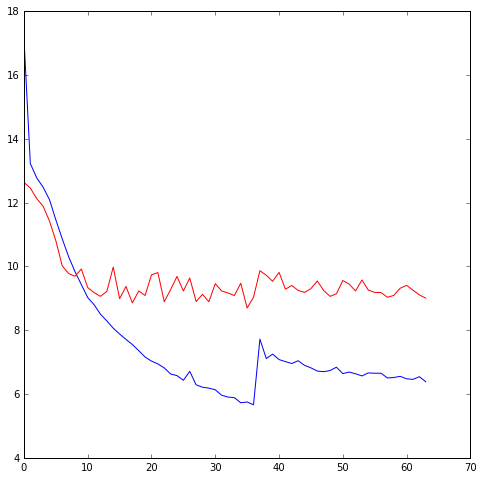

In [295]:
plt.figure(figsize=(8,8))
idx = train_loss_total != 0
plt.plot(train_loss_total[idx], 'b')
plt.plot(test_loss_total[idx], 'r')

In [296]:
gen = generate_data(test_annotations[np.random.random_integers(0, test_annotations.size - 1, size=(100,))])

In [297]:
testdat = [t for t in gen]

In [298]:
Xtest, ytest = testdat[0]

In [299]:
out_fn = theano.function([yl.input], yl.output_test)

In [300]:
Xtest_out = out_fn(Xtest)

In [301]:
def draw_best(im, output):
    idx = (output[[4,9]]).argmax()
    idx = np.unravel_index(idx, output[[4,9]].shape)
    coord = output[5 * idx[0]:5 * idx[0] + 4, idx[1], idx[2]]
    obj_score = output[5 * idx[0] + 4, idx[1], idx[2]]
    class_score = output[-4:, idx[1], idx[2]]

    xi = int(im.shape[1] * (coord[0] + 1./S[1] * idx[2]))
    yi = int(im.shape[0] * (coord[1] + 1./S[0] * idx[1]))
    xf = xi + int(coord[2] * im.shape[1])
    yf = yi + int(coord[3] * im.shape[0])
    
    xi, yi = max(0, xi), max(0, yi)
    xf, yf = min(im.shape[1]-1 , xf), min(im.shape[0]-1, yf)

    draw_im = np.copy(im)
    draw_im[yi,xi:xf] = [1,0,0]
    draw_im[yf,xi:xf] = [1,0,0]
    draw_im[yi:yf,xi] = [1,0,0]
    draw_im[yi:yf,xf] = [1,0,0]
    
    tmp = np.zeros((im.shape[0] + 10, im.shape[1] + 10) + im.shape[2:])
    tmp[5:-5,5:-5] = draw_im
    draw_im = tmp

    return draw_im, obj_score, class_score, coord

In [302]:
def get_label_from_num(label):
    if label == 0:
        return 'car'
    elif label == 1:
        return 'bicycle'
    elif label == 2:
        return 'bike'
    elif label == 3:
        return 'person'
    elif label == 4:
        return 'noobj'
    else:
        return

In [303]:
swap = lambda x: x.swapaxes(0,1).swapaxes(1,2)

In [371]:
N = int(Xtest.shape[0] * np.random.rand())
print N
a,b,c,d = draw_best(swap(Xtest[N]), Xtest_out[N])

51


car with class score: 0.819, objectness: 0.098
[ 0.81881565  0.01448479  0.09895717  0.06774228]
[ 0.5118134   0.3052038   0.28313911  0.29463091]


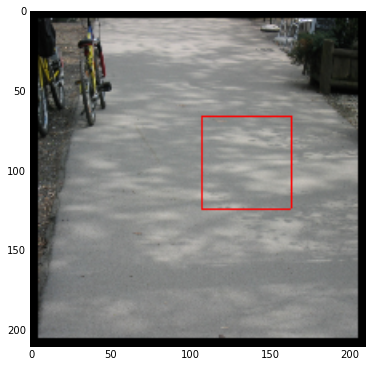

In [372]:
plt.figure(figsize=(6,6))
plt.imshow(a)
print '%s with class score: %.3f, objectness: %.3f' % (get_label_from_num(c.argmax()), c.max(), b)
print c
print d

In [348]:
im = swap(Xtest[int(np.random.rand()*Xtest.shape[0])])

In [ ]:
im2 = rgb2hsv(im)

In [ ]:
im2[:,:,1:] *= (1. + .3 * np.random.rand(1,1,2))

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(hsv2rgb(im2))

In [ ]:
im3 = hsv2rgb(im2)